<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/book/Meta_learning_EFL_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Introduction

This notebook was used to conduct a research of a agnostic-model for systematics literatures reviews classification, using [Entailment as Few-shot classification](https://arxiv.org/abs/2104.14690) and [first-order meta-learning algorithms](https://arxiv.org/abs/1803.02999) with a pre-trained language model [SciBERT](https://arxiv.org/abs/1903.10676).

The etailment text used was "It is a great text.".

## Requirements

In [1]:
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!pip install wandb -qU

# !pip install sparsezoo
!pip install matplotlib==3.5.1
# !pip install onnx2torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

# 🌊 Useful Functions

Useful function to conduct the research

## Random


In [3]:
import random

# Random seed function
def random_seed(value):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Tasks for meta-learner
def create_batch_of_tasks(taskset, is_shuffle = True, batch_size = 4):
    idxs = list(range(0,len(taskset)))
    if is_shuffle:
        random.shuffle(idxs)
    for i in range(0,len(idxs), batch_size):
        yield [taskset[idxs[i]] for i in range(i, min(i + batch_size,len(taskset)))]


## Diagnosis

### Framework

In [4]:
# Prepare data to process by Domain-learner
def prepare_data(data, batch_size, tokenizer,max_seq_length,
                 input = 'text', output = 'label',
                 train_size_per_class = 5, global_datasets = False,
                 treat_text_fun =None):
  data = data.reset_index().drop("index", axis=1)

  if global_datasets:
    global data_train, data_test

  # Sample task for training
  data_train = data.groupby('label').sample(train_size_per_class, replace=False)
  idex = data.index.isin(data_train.index)

  # The Test set to label by the model
  data_test = data[~idex].reset_index()


  # Transform in dataset to model
  ## Train
  dataset_train = SLR_DataSet(
    data = data_train.sample(frac=1),
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length,
    treat_text =treat_text_fun)

  ## Test
  dataset_test = SLR_DataSet(
    data = data_test,
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length,
    treat_text =treat_text_fun)
  
  # Dataloaders
  ## Train 
  data_train_loader = DataLoader(dataset_train,
                           shuffle=True,
                          #  sampler = sampler,
                           batch_size=batch_size['train']
                            )
  ## Test
  if len(dataset_test) % batch_size['test'] == 1 :
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=True)
  else:
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=False)

  return data_train_loader, data_test_loader, data_train, data_test


In [5]:
from tqdm import tqdm

# Meta trainer
def meta_train(data, model, Info,
               print_epoch =True, size_layer=0,
                Test_resource =None,
                treat_text_fun =None):

  # Meta-learner model
  learner = Learner(model = model, **Info)
  
  # Testing tasks
  if isinstance(Test_resource, pd.DataFrame):
    test = MetaTask(Test_resource, num_task = 0, k_support=10, k_query=10,
                  training=False,treat_text =treat_text_fun, **Info)


  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

  # Meta epoch (Outer epoch)
  for epoch in tqdm(range(Info['meta_epoch']), desc= "Meta epoch ", ncols=80):
      
      # Train tasks
      train = MetaTask(data,
                      num_task = Info['num_task_train'],
                      k_support=Info['k_qry'],
                      k_query=Info['k_spt'],
                      treat_text =treat_text_fun, **Info)

      # Batch of train tasks
      db = create_batch_of_tasks(train, is_shuffle = True, batch_size = Info["outer_batch_size"])

      if print_epoch:
      # Outer loop bach training
        for step, task_batch in enumerate(db):          
            print("\n-----------------Training Mode","Meta_epoch:", epoch ,"-----------------\n")
            
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, valid_train= print_epoch)
            print('Step:', step, '\ttraining Acc:', acc)
        
        if isinstance(Test_resource, pd.DataFrame):
          # Validating Model
          if ((epoch+1) % 4) + step == 0:
              random_seed(123)
              print("\n-----------------Testing Mode-----------------\n")
              
              # Batch of test tasks
              db_test = create_batch_of_tasks(test, is_shuffle = False, batch_size = 1)
              acc_all_test = []

              # Looping testing tasks
              for test_batch in db_test:
                  acc = learner(test_batch, training = False)
                  acc_all_test.append(acc)

              print('Test acc:', np.mean(acc_all_test))
              del acc_all_test, db_test

              # Restarting training randomly
              random_seed(int(time.time() % 10))

      else:
        for step, task_batch in enumerate(db):
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, print_epoch, valid_train= print_epoch)

  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

In [6]:
def train_loop(data_train_loader, data_test_loader, modelx,
               device, epoch = 4, lr = 1, print_info = True,name = 'name',
               wandb= None, attempt=1, tsne= True):
  # Start the model's parameters
  model = deepcopy(modelx)
  optimizer = Adam(model.parameters(), lr=lr)

  model.to(device)
  model.train()

  # Task epoch (Inner epoch)
  for i in range(0, epoch):

      all_loss = []

      # Inner training batch (support set)
      for inner_step, batch in enumerate(data_train_loader):
          batch = tuple(t.to(device) for t in batch)
          input_ids, attention_mask,q_token_type_ids, label_id = batch
          
          # Inner Feedfoward
          loss, (_, logit), _ = model(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())
          
          # compute grads
          loss.backward()

          # update parameters
          optimizer.step()
          optimizer.zero_grad()
          
          all_loss.append(loss.item())
    
      # if type(wandb) != None:
    
      #   # print(logit.to('cpu'))
      #   print(label_id.to('cpu'))
      #   metrics = plot(logit.to('cpu'),  0,
      #                   label_id.to('cpu'), 0.9,
      #                   save = False, make_plot = False, 
      #                   print_stats = False,
      #                   show = False)
        
      #   metrics['loss'] = np.mean(all_loss)
      #   metrics['attempt'] = attempt

      #   wandb.log(metrics)

      if (i % 2 == 0) & print_info:
          print("Loss: ",np.mean(all_loss))


  # Test evaluation
  model.eval()
  all_loss = []
  all_acc = []
  features = []
  labels = []
  predi_logit = []

  with torch.no_grad():
      # Test's Batch loop
      for inner_step, batch in enumerate(tqdm(data_test_loader,
                                              desc="Test validation | " + name,
                                              ncols=80)) :
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask,q_token_type_ids, label_id = batch

        # Predictions
        _, feature, prediction = model(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())

        # Save batch's predictions 
        prediction = prediction.detach().cpu().squeeze()
        label_id = label_id.detach().cpu()
        labels.append(label_id.numpy().squeeze())
        
        logit = feature[1].detach().cpu()
        predi_logit.append(logit.numpy())

        feature_lat = feature[0].detach().cpu()
        features.append(feature_lat.numpy())

        # Accuracy over the test's bach
        acc = fn.accuracy(prediction, label_id).item()
        all_acc.append(acc)
      del input_ids, attention_mask, label_id, batch

  if print_info:
    print("acc:", np.mean(all_acc))

  model.to('cpu')
  gc.collect()
  torch.cuda.empty_cache()

  del model, optimizer
  
  return map_feature_tsne(features, labels, predi_logit, tsne)

# Process predictions and map the feature_map in tsne
def map_feature_tsne(features, labels, predi_logit, tsne= True):
  
  features = np.concatenate(np.array(features,dtype=object))
  features = torch.tensor(features.astype(np.float32)).detach().clone()
  
  labels = np.concatenate(np.array(labels,dtype=object))
  labels = torch.tensor(labels.astype(int)).detach().clone()

  logits = np.concatenate(np.array(predi_logit,dtype=object))
  logits = torch.tensor(logits.astype(np.float32)).detach().clone()

  if tsne:
  # Dimention reduction
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random').fit_transform(features.detach().clone())
  else:
    X_embedded=0
  return logits.detach().clone(), X_embedded, labels.detach().clone(), features.detach().clone()
  


In [7]:
def wss_calc(logit, labels, trsh = 0.5):
  
  # Prediction label given the treshould
  predict_trash = torch.sigmoid(logit).squeeze() >= trsh
  
  # Compute confusion matrix values
  CM = confusion_matrix(labels, predict_trash.to(int), labels = [0,1])
  tn, fp, fne, tp = CM.ravel()

  P = (tp + fne)  
  N = (tn + fp) 
  recall = tp/(tp+fne)

  # WSS
  wss = (tn + fne)/len(labels) -(1- recall)

  # AWSS
  awss = (tn/N - fne/P)

  return {
      "wss": round(wss,4),
      "awss": round(awss,4),
      "R": round(recall,4),
      "CM": CM
      }

In [8]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.gridspec import GridSpec

# Compute the metrics
def plot(logits, X_embedded, labels, tresh, show = True,
         namefig = "plot", make_plot = True,
         print_stats = True, save = True,
         with_tsne = False):
  col = pd.MultiIndex.from_tuples([
                                   ("Predict", "0"),
                                   ("Predict", "1")
                                   ])
  index = pd.MultiIndex.from_tuples([
                                   ("Real", "0"),
                                   ("Real", "1")
                                   ])

  predict = torch.sigmoid(logits).detach().clone().squeeze()

  # Roc curve
  fpr, tpr, thresholds = roc_curve(labels, predict)

  # Given by a Recall of 95% (treshould avaliation)
  ## WSS
  ### Index to recall
  idx_wss95 = sum(tpr < 0.95)
  ### Treshould
  thresholds95 = thresholds[idx_wss95]
  # print(logits,labels, thresholds95)
  ### Compute the metrics
  wss95_info = wss_calc(logits,labels, thresholds95 )
  acc_wss95 = fn.accuracy(predict, labels, threshold=thresholds95)
  f1_wss95 = fn.f1_score(predict, labels, threshold=thresholds95)


  # Given by a treshould (recall avaliation)
  ### Compute the metrics
  wss_info = wss_calc(logits,labels, tresh )
  acc_wssR = fn.accuracy(predict, labels, threshold=tresh)
  f1_wssR = fn.f1_score(predict, labels, threshold=tresh)


  metrics= {
      # WSS
      "WSS@95": wss95_info['wss'],
      "AWSS@95": wss95_info['awss'],
      "WSS@R": wss_info['wss'],
      "AWSS@R": wss_info['awss'],
      # Recall
      "Recall_WSS@95": wss95_info['R'],
      "Recall_WSS@R": wss_info['R'],
      # acc
      "acc@95": acc_wss95.item(),
      "acc@R": acc_wssR.item(),
      # f1
      "f1@95": f1_wss95.item(),
      "f1@R": f1_wssR.item(),
      # treshould 95
      "treshould@95": thresholds95
  }

  # Print stats
  if print_stats:
    wss95= f"WSS@95:{wss95_info['wss']}, R: {wss95_info['R']}"
    wss95_adj= f"ASSWSS@95:{wss95_info['awss']}"
    print(wss95)
    print(wss95_adj)
    print('Acc.:', round(acc_wss95.item(), 4))
    print('F1-score:', round(f1_wss95.item(), 4))
    print(f"Treshold to wss95: {round(thresholds95, 4)}")
    cm = pd.DataFrame(wss95_info['CM'],
              index=index,
              columns=col)
    
    print("\nConfusion matrix:")
    print(cm)
    print("\n---Metrics with threshold:", tresh, "----\n")
    wss= f"WSS@R:{wss_info['wss']}, R: {wss_info['R']}"
    print(wss)
    wss_adj= f"AWSS@R:{wss_info['awss']}"
    print(wss_adj)
    print('Acc.:', round(acc_wssR.item(), 4))
    print('F1-score:', round(f1_wssR.item(), 4))
    cm = pd.DataFrame(wss_info['CM'],
                index=index,
                columns=col)
      
    print("\nConfusion matrix:")
    print(cm)

  # Plots

  if make_plot:
    
    fig = plt.figure( figsize=(15,15))
    gs = GridSpec(2, 2, figure=fig)
    plt.rcParams.update({'font.size': 20})


    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    # ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    
    alpha = torch.squeeze(predict).numpy()

    if with_tsne:

      # TSNE
      p1 = sns.scatterplot(x=X_embedded[:, 0],
                    y=X_embedded[:, 1],
                    hue=labels,
                    alpha=alpha, ax = ax1).set_title('Predictions-TSNE')
      
      
      # WSS@95
      t_wss = predict >= thresholds95
      t_wss = t_wss.squeeze().numpy()
      p2 = sns.scatterplot(x=X_embedded[t_wss, 0],
                    y=X_embedded[t_wss, 1],
                    hue=labels[t_wss],
                    alpha=alpha[t_wss], ax = ax2).set_title('WSS@95')

    # # WSS@R
    # t = predict >= tresh
    # t = t.squeeze().numpy()
    # p3 = sns.scatterplot(x=X_embedded[t, 0],
    #               y=X_embedded[t, 1],
    #               hue=labels[t],
    #               alpha=alpha[t], ax = ax3).set_title(f'Predictions-Treshold {tresh}')
    
    # print(labels)
    p4 = sns.kdeplot(x=predict,
                     hue=labels,
                    #  bw_adjust=.5,
                     cut=0, fill=True,
                     common_norm=True, #, palette="crest",
                     alpha=.5, linewidth=0,
                    #  palette = dict('0'="#eba605",
                    #                 '1'="#0587eb"),
                     ax = ax5).set_title(f'Output density predictions')
    ax5.axvline(thresholds95, color='r')
    # ax5.set_xlim(0, 1)

    # ROC-Curve
    roc_auc = auc(fpr, tpr)
    lw = 2
    ax4.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc)
    ax4.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax4.axhline(y=0.95, color='r', linestyle='-')
    ax4.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title= "ROC")
    ax4.legend(loc="lower right")

    if show:
      plt.show()
    
    if save:
      fig.savefig(namefig, dpi=fig.dpi)

  return metrics

def auc_plot(logits,labels, color = "darkorange", label = "test"):
    predict = torch.sigmoid(logits).detach().clone()
    fpr, tpr, thresholds = roc_curve(labels, predict.squeeze())
    roc_auc = auc(fpr, tpr)
    lw = 2

    label = label + str(round(roc_auc,2))
    # print(label)

    plt.plot(
      fpr,
      tpr,
      color=color,
      lw=lw,
      label= label 
      )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.axhline(y=0.95, color='r', linestyle='-')

### Visual exploration

In [9]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Interface to evaluation
class diagnosis():
  def __init__(self, names, Valid_resource, batch_size_test, model,Info,start = 0,
    treat_text_fun=None):
    self.names=names
    self.Valid_resource=Valid_resource
    self.batch_size_test=batch_size_test
    self.model=deepcopy(model)
    self.start=start 
    self.treat_text_fun=treat_text_fun
    self.Info=Info

    # BOX INPUT
    self.value_trash = widgets.FloatText(
        value=0.95,
        description='tresh',
        disabled=False
    )
    self.valueb = widgets.IntText(
        value=10,
        description='size',
        disabled=False
    )

    # Buttons
    self.train_b = widgets.Button(description="Train")
    self.next_b = widgets.Button(description="Next")
    self.eval_b = widgets.Button(description="Evaluation")

    self.hbox = widgets.HBox([self.train_b, self.valueb])

    # Click buttons functions
    self.next_b.on_click(self.Next_button)
    self.train_b.on_click(self.Train_button)
    self.eval_b.on_click(self.Evaluation_button)


  # Next button
  def Next_button(self,p):
    clear_output()
    self.i=self.i+1

    # Select the domain data
    self.domain = names[self.i]
    self.data = self.Valid_resource[self.Valid_resource['domain'] == self.domain]
    
    print("Name:", self.domain)
    print(self.data['label'].value_counts())
    display(self.hbox)
    display(self.next_b)


  # Train button
  def Train_button(self, y):
    clear_output()
    print(self.domain)

    # Prepare data for training (domain-learner)
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = self.valueb.value,
              batch_size = {'train': self.Info['inner_batch_size'],
                            'test': batch_size_test},
              max_seq_length = self.Info['max_seq_length'],
              tokenizer = self.Info['tokenizer'],
              input = "text",
              output = "label",
              treat_text_fun=self.treat_text_fun)

    # Train the model and predict in the test set
    self.logits, self.X_embedded, self.labels, self.features = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.Info['device'],
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = self.domain)

    tresh_box = widgets.HBox([self.eval_b, self.value_trash])
    display(self.hbox)
    display(tresh_box)
    display(self.next_b)


  # Evaluation button
  def Evaluation_button(self, te):
    clear_output()
    tresh_box = widgets.HBox([self.eval_b, self.value_trash])

    print(self.domain)
    # print("\n")
    print("-------Train data-------")
    print(data_train['label'].value_counts())
    print("-------Test data-------")
    print(data_test['label'].value_counts())
    # print("\n")
    
    display(self.next_b)
    display(tresh_box)
    display(self.hbox)

    # Compute metrics    
    metrics = plot(self.logits, self.X_embedded, self.labels,
                    tresh=self.Info['tresh'], show = True,
                    # namefig= "./"+base_path +"/"+"Results/size_layer/"+ name_domain+'/' +str(n_layers) + '/img/' + str(attempt) + 'plots',
                    namefig= 'test',
                  make_plot = True,
                  print_stats = True,
                  save=False,
                   with_tsne = True)

  def __call__(self):
    self.i= self.start-1
    clear_output()
    display(self.next_b)

## Simulation attemps

In [10]:
import os
import shutil

# Save google drive
########################################################################################################################
# Define os diretórios A e B

# def create_google_save(path):




def save_google(path_in, path_out = False):
  # diretorio_a = path_out if path_out else '/content/gdrive/MyDrive'
  diretorio_a = path_out
  # diretorio_a = '/content/gdrive/MyDrive'

  # diretorio_b = model_path
  # diretorio_b = meta_info_path

  # Cria a pasta "RESULTADOS" em A
  caminho_resultados = os.path.join(diretorio_a, 'RESULTADOS_SLR')

  try: 
    os.makedirs(caminho_resultados) 
  except:
    print("Created or already existist dir:", caminho_resultados)
    # Move a pasta do diretório B para a pasta "RESULTADOS" em A

  shutil.move(path_in, caminho_resultados)
  print("saved:", os.path.join(caminho_resultados, path_in))


  
########################################################################################################################


from collections import defaultdict

# Simulation attemps of domain learner
def pipeline_simulation(Valid_resource, names_to_valid, path_save, model, Info,
                        treat_text_fun, initializer_model,
                        n_attempt=5, batch_test = 100, wandb=None, epochs=[4],
                        tsne=True, make_plot = True):

  # Create a directory to save informations
  for name in names_to_valid:
    name = re.sub("\.csv", "",name)
    
    Path(path_save  + name + "/img").mkdir(parents=True, exist_ok=True)

  # Dict to sabe roc curves
  roc_stats = defaultdict(lambda: defaultdict(
      lambda: defaultdict(
          list
          )
      )
  )


  # tbl = wandb.Table(columns=['WSS@95', 'AWSS@95', 'WSS@R',
  #                            'AWSS@R', 'Recall_WSS@95',
  #                            'Recall_WSS@R', 'acc@95',
  #                            'acc@R', 'f1@95', 'f1@R',
  #                            'treshould@95', 'name',
  #                            'layer_size', 'attempt',
  #                            'epochs', 'Image'])

  try:
    metrics_csv = pd.read_csv(path_save+ "metrics.csv")
    all_metrics = metrics_csv.to_dict('records')
    # print(all_metrics)
    print("Alredy exist: metrics.csv")
  except:
    all_metrics = []
    print("Dont exist: metrics.csv, creating a new one.")

  # Loop over a list of domains
  for name in names_to_valid:
    
    # Select a domain dataset
    data = Valid_resource[Valid_resource['domain'] == name].reset_index().drop("index", axis=1)

    # Attempts simulation
    for attempt in range(n_attempt):
      print("---"*4,"attempt", attempt, "---"*4)
      
      # Prepare data to pass to the model
      data_train_loader, data_test_loader,  _ , _ = prepare_data(data,
                train_size_per_class = Info['k_spt'],
                batch_size = {'train': Info['inner_batch_size'],
                              'test': batch_test},
                max_seq_length = Info['max_seq_length'],
                tokenizer = Info['tokenizer'],
                input = "text",
                output = "label",
                treat_text_fun= treat_text_fun)

      for epoch in epochs:
        
        # Train the model and evaluate on the test set of the domain
        logits, X_embedded, labels, features = train_loop(data_train_loader, data_test_loader,
                                                          model, device,
                                                          epoch = epoch,
                                                          lr=Info['inner_update_lr'],
                                                          print_info=False,
                                                          name = name, wandb=wandb,
                                                          attempt=attempt, tsne= tsne)
        
        
        name_domain = re.sub("\.csv", "",name)
        path_name = path_save  + name_domain + "/img/" + str(attempt) +'_'+ str(epoch) + 'plots'
        # Compute the metrics
        metrics = plot(logits, X_embedded, labels,
                      tresh=Info['tresh'], show = False,
                      namefig= path_name,
          make_plot = make_plot, print_stats = False, save =  make_plot,
          with_tsne = tsne)

        # Compute the roc-curve
        fpr, tpr, _ = roc_curve(labels, torch.sigmoid(logits).squeeze())
        
        # Save the correspoud information of the domain
        metrics['name'] = name_domain
        metrics['layer_size'] = Info['bert_layers']
        metrics['attempt'] = attempt
        metrics['epochs'] = epoch
        metrics['DataTrainSize'] = Info['k_spt']
        roc_stats[name_domain][str(Info['bert_layers'])]['fpr'].append(fpr.tolist())
        roc_stats[name_domain][str(Info['bert_layers'])]['tpr'].append(tpr.tolist())
        all_metrics.append(metrics)

        # Save the metrics and the roc curve  of the attemp
        temp_dat = pd.DataFrame(all_metrics)
        temp_dat = temp_dat.loc[:, ~temp_dat.columns.str.contains('^Unnamed')]
        
        temp_dat.to_csv(path_save+ "metrics.csv")

        # save_google(path_save  + "metrics.csv")
        # save_google(path_name)
        
        roc_path =  path_save + "roc_stats.json"
        with open(roc_path, 'w') as fp:
            json.dump(roc_stats, fp)

        # if type(wandb) != None:
        #   met = metrics.copy()
        #   met['Image'] = wandb.Image(path_name + '.png')
        #   # met['Image'] = '.png'
          
        #   print(list(met.values()))
        #   v=list(met.values())
        #   tbl.add_data(*v)
        #   # tbl = wandb.Table(columns= met, 
        #   #                   data=dat)
        #   # print(met)
        #   # print(met.keys())
        #   # dat = pd.DataFrame(all_metrics)
        #   # tbl = wandb.Table(data=dat)

        #   # metrics.pop('Image')          

        del fpr, tpr, logits, X_embedded, labels
        del features, metrics,  _ , temp_dat
    
    
    # wandb.log({'Results': tbl})
    




  # Save the information used to evaluate the validation resource
  save_info = Info.copy()
  save_info['model'] = initializer_model.tokenizer.name_or_path
  save_info.pop("tokenizer")
  save_info.pop("bert_layers")
  save_info.pop("device")

  info_path =  path_save+"info.json"
  with open(info_path, 'w') as fp:
      json.dump(save_info, fp)

## Statistics

In [11]:
# Loading dataset statistics
def load_data_statistics(paths):
  size = []
  pos = []
  neg = []
  for p in paths:
    data = pd.read_csv(p) 
    data = data.dropna()
    # Dataset size
    size.append(len(data))
    # Number of positive labels
    pos.append(data['labels'].value_counts()[1])
    # Number of negative labels
    neg.append(data['labels'].value_counts()[0])
  del data

  info_load = pd.DataFrame({
      "size":size,
      "pos":pos,
      "neg":neg,
      "names":names,
      "paths": paths })
  return info_load

# Loading the datasets
def load_data(train_info_load):

  col = ['abstract','title', 'labels', 'domain']

  data_train = pd.DataFrame(columns=col)
  for p in train_info_load['paths']:  
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp['domain'] = os.path.basename(p)
    data_train = pd.concat([data_train, data_temp])
    
  data_train['text'] = data_train['title'] + data_train['abstract'].replace(np.nan, '')

  return( data_train \
            .replace({"labels":{0:"negative", 1:'positive'}})\
            .rename({"labels":"label"} , axis=1)\
            .loc[ :,("text","domain","label")]
        )

# 🌊 Importing data

The 64 topic-agnostic labeled datasets proposed can be downloaded and mounted below:

In [12]:
!wget -O data.zip https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
!unzip data.zip

--2023-04-12 19:30:36--  https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea [following]
--2023-04-12 19:30:36--  https://www.dropbox.com/sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd1bb0468cb6af400902e78eab2.dl.dropboxusercontent.com/zip_download_get/Bdcagi-1DJNLZZJGoCiGyKWkEUmAMQoantZ168GgUWYq3rIZN7VS9qvqMrKIEJdXbzT-6sqwcqUD_kkUm0Y0SYDqzqxZXtTUWcJ5w-p6MNBDFA# [following]
--2023-04-12 19:30:37--  https://ucd1bb0468cb6af400902e78eab2.dl.dropboxusercontent.com/zip_download_get/Bdcagi-1DJNLZZJGoCiGyKWkEUmAMQoantZ168GgUWYq3rIZN7VS9qvqMrKIEJdXbzT-6sqwcqUD_kkUm0Y0SYDqzqxZ

In [13]:
import glob
import os

# Paths and names of the domains datasets
path = 'SLR_data'
paths = glob.glob(f"{path}/**/*.csv", recursive=True)
pprint(paths)

names = [os.path.basename(p) for p in paths]

['SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR2_Meng.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR1_Yang.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR10_Kourbeti.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR4_Li.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR7_Zhou.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR3_Segelov.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR5_Lv.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR6_Wang.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance al

## Evaluate text data

Some pre analysis of the text is required to handle with the miss/over information 

In [14]:
#@title Untreated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
from pprint import pprint
import unicodedata

# Loading data
def handle_data(path):
  data = pd.read_csv(path)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = unicodedata.normalize("NFKD",str(text))
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()
i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

### Treat text data



In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import unicodedata
import re


# Undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

class treat_text:
  def __init__(self, patterns):
    self.patterns = patterns

  def __call__(self,text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(self.patterns,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

# Regex multiple replace function
def multiple_replace(dict, text):

  # Building regex from dict keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # Substitution
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 



treat_text_fun = treat_text(patterns)

In [16]:
#@title Treated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re


def handle_data(path):
  data = pd.read_csv(path)
  # print('Columns:')
  # print(data.columns)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = treat_text_fun(text)
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()

i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

# 🌊 Downloading pre-trained model


In [17]:
# Fetching pre-trained model and tokenizer
class initializer:
  def __init__(self, MODEL_NAME, **config):    
    self.MODEL_NAME = MODEL_NAME

    model = config.get("model")
    tokenizer = config.get("tokenizer")

    # Model
    self.model = model.from_pretrained(MODEL_NAME, 
                                       return_dict=True,
                                       output_attentions = False)
    # Tokenizer
    self.tokenizer = tokenizer.from_pretrained(MODEL_NAME,
                                               do_lower_case = True)

In [18]:
# Model and tokenizer of choice
config = {
    "model": AutoModelForSequenceClassification,
    "tokenizer": AutoTokenizer
     }

# Pre-trained model initializer (uncased sciBERT)
# initializer_model = initializer('neuralmagic/oBERT-12-upstream-pruned-unstructured-90-v2', **config)
# initializer_model = initializer('allenai/scibert_scivocab_uncased', **config)
initializer_model = initializer('sentence-transformers/paraphrase-mpnet-base-v2', **config)


Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at sentence-transformers/paraphrase-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN t

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

# 🌏⚡ Meta-Learner - Systematic Literature Review Classifier (ML-SLRC)

Functions based on the repository: https://github.com/mailong25/meta-learning-bert

In [ ]:
#@title loop helper

import torch
from tqdm import tqdm
import gc
from IPython.display import clear_output
from collections import namedtuple

features = namedtuple('features', ['bert', 'feature_map'])
Output = namedtuple('Output', ['loss', 'features', 'logit'])

bert_tuple = namedtuple('bert',['hidden_states', 'attentions'])



class loop():
  
  @classmethod
  def train_loop(self, model,device, optimizer, data_train_loader, scheduler = None, data_valid_loader =  None,
                epochs = 4, print_info = 1000000000, metrics = True, log = None, metrics_print = True):
    # Start the model's parameters

    table.reset()
    model.to(device)
    model.train()

    # Task epochs (Inner epochs)
    for epoch in range(0, epochs):
      train_loss, _, out = self.batch_loop(data_train_loader, model, optimizer, device)
      
      if scheduler is not None:
          for sched in scheduler:
            sched.step()

      if (epoch % print_info == 0):
        if metrics:
          labels = self.map_batch(out[1]).to(int).squeeze()
          logits = self.map_batch(out[0]).squeeze()

          train_metrics, _ = plot(logits, labels, 0.9)

          del labels, logits

          train_metrics['Loss'] =  torch.Tensor(train_loss).mean().item() 
          
          if not isinstance(log,type(None)):
            log({"train_"+ x :y for x,y in train_metrics.items()})

          table(train_metrics, epoch, "Train")

        else:
          print("Loss: ", torch.Tensor(train_loss).mean().item())
  
        if  data_valid_loader:
          valid_loss, _, out = self.eval_loop(data_valid_loader, model, device=device)          
          if metrics:
            global out2
            out2 = out
            labels = self.map_batch(out[1]).to(int).squeeze()
            logits = self.map_batch(out[0]).squeeze()

            valid_metrics, _ = plot(logits, labels, 0.9)
            valid_metrics['Loss'] =  torch.Tensor(valid_loss).mean().item()
            
            del labels, logits 
    
            if not isinstance(log,type(None)):
              log({"valid_"+ x :y for x,y in train_metrics.items()})
            
            table(valid_metrics, epoch, "Valid")

            if metrics_print:
              print(table.data_frame().round(4))

          else:
            print("Valid Loss: ", torch.Tensor(valid_loss).mean().item())

    return table.data_frame()

  @classmethod
  def batch_loop(self, loader, model, optimizer, device):
    all_loss = []
    features_lst = []
    attention_lst = []
    logits = []
    outputs = []

    # Test's Batch loop
    for inner_step, batch in enumerate(tqdm(loader,
                                            desc="Train validation | ",
                                            ncols=80)) :
      input, output =batch
      input = tuple(t.to(device) for t in input)
      
      if isinstance(output, torch.Tensor):
        output = output.to(device)

      
      optimizer.zero_grad()
      
      # Predictions
      loss, feature, logit = model(input, output)

      # compute grads
      loss.backward()

      # update parameters
      optimizer.step()


      input = tuple(t.to("cpu") for t in input)
      
      if isinstance(output, torch.Tensor):
        output = output.to("cpu")

      if isinstance(loss, torch.Tensor):
        all_loss.append(loss.to('cpu').detach().clone())

      if isinstance(logit, torch.Tensor):
        logits.append(logit.to('cpu').detach().clone())

      
      if isinstance(output, torch.Tensor):
        outputs.append(output.to('cpu').detach().clone())        
      
      if len(feature.feature_map)!=0:
        features_lst.append([x.to('cpu').detach().clone() for x in feature.feature_map])


      del batch, input, output, loss, feature, logit

    # model.to('cpu')
    gc.collect()
    torch.cuda.empty_cache()

    # del model, optimizer

    return Output(all_loss, features(None,features_lst), (logits, outputs))

  @classmethod
  def eval_loop(self, loader, model, device, attention= False, hidden_states=False):
    all_loss = []
    features_lst = []
    attention_lst = []
    hidden_states_lst = []
    logits = []
    outputs = []
    model.eval()

    with torch.no_grad():
      # Test's Batch loop
      for inner_step, batch in enumerate(tqdm(loader,
                                              desc="Test validation | ",
                                              ncols=80)) :
        input, output =batch
        input = tuple(t.to(device) for t in input)

        
        if output.numel()!=0:          
          # Predictions
          loss, feature, logit = model(input, output.to(device),
                                            attention= attention, hidden_states=hidden_states)
        else:
          # Predictions
          loss, feature, logit = model(input,
                                            attention= attention, hidden_states=hidden_states)


        input = tuple(t.to("cpu") for t in input)
        
        if isinstance(output, torch.Tensor):
          output = output.to("cpu")

        if isinstance(loss, torch.Tensor):
          all_loss.append(loss.to('cpu').detach().clone())

        if isinstance(logit, torch.Tensor):
          logits.append(logit.to('cpu').detach().clone())

        try:
          if not isinstance(feature.bert.attentions, type(None)):
            attention_lst.append([x.to('cpu').detach().clone() for x in feature.bert.attentions])
        except:
          attention_lst = None

        try:
          if not isinstance(feature.bert.hidden_states, type(None)):
            hidden_states_lst.append([x.to('cpu').detach().clone() for x in feature.bert.hidden_states])
        except:
          hidden_states_lst = None
        
        if isinstance(output, torch.Tensor):
          outputs.append(output.to('cpu').detach().clone())        
        
        if len(feature.feature_map)!=0:
          features_lst.append([x.to('cpu').detach().clone() for x in feature.feature_map])


        del batch, input, output, loss, feature, logit

      # model.to('cpu')
      gc.collect()
      torch.cuda.empty_cache()

      # del model, optimizer

      return Output(all_loss, features(bert_tuple(hidden_states_lst,attention_lst),features_lst), (logits, outputs))

  # Process predictions and map the feature_map in tsne
  @staticmethod
  def map_batch(features):
    features = torch.cat(features, dim =0)
    # features = np.concatenate(np.array(features,dtype=object)).astype(np.float32)
    # features = torch.tensor(features)
    return features.detach().clone()


class table:
  data = []
  index = []

  @torch.no_grad()
  def __init__(self, data, epochs, name):
    self.index.append((epochs, name))
    self.data.append(data)


  @classmethod
  @torch.no_grad()
  def data_frame(cls):
    clear_output()
    index = pd.MultiIndex.from_tuples(cls.index, names=["Epochs", "Data"])
    data = pd.DataFrame(cls.data,  index=index)
    return data

  @classmethod
  @torch.no_grad()
  def reset(cls):
    cls.data = []
    cls.index = []



## 💀 Domain Learner

Domain learner is the phase that the model learn one task as a singular model

In [ ]:
class Adapters(nn.Module):
  def __init__(self, n=64, config_size=10):
    super(Adapters, self).__init__()
    
    self.adapter = nn.Sequential(
            nn.Linear(config_size, n),
            nn.Tanh(),
            nn.Linear(n, config_size),
        )
    
  def forward(self, x):
    return self.adapter(x) + x
    

f = Adapters(12)

# Pre-trained model
class Encoder(nn.Module):
  def __init__(self, layers, freeze_bert, model, arch='mpnet'):
    super(Encoder, self).__init__()

    

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    
    # Pre-trained model
    self.model = deepcopy(model)

    # Freezing bert parameters
    if freeze_bert:
      for param in self.model.parameters():
        param.requires_grad = not freeze_bert

    # Selecting hidden layers of the pre-trained model
    old_model_encoder = self.model.encoder.layer
    new_model_encoder = nn.ModuleList()
    

# Adapters   
    for i in layers:
      if freeze_bert:
        if arch == 'mpnet':

          for params in old_model_encoder[i].attention.LayerNorm.parameters():
            params.requires_grad = True

          old_model_encoder[i].attention.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].attention.LayerNorm)

          for params in old_model_encoder[i].output.LayerNorm.parameters():
            params.requires_grad = True

          old_model_encoder[i].output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].output.LayerNorm)
        
        elif arch == 'bert':
          for params in old_model_encoder[i].attention.output.LayerNorm.parameters():
            params.requires_grad = True
          
          old_model_encoder[i].attention.output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].attention.output.LayerNorm)

          for params in old_model_encoder[i].output.LayerNorm.parameters():
            params.requires_grad = True
          
          old_model_encoder[i].output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].output.LayerNorm)

      new_model_encoder.append(old_model_encoder[i])

    self.model.encoder.layer = new_model_encoder
  
  # Feed forward
  def forward(self, **x):
    
    return self.mean_pooling(self.model(**x), x['attention_mask']) 
    # return self.model(**x)[0][:,0,:]

  def mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Complete model
class SLR_Classifier(nn.Module):
  def __init__(self, **data):
    super(SLR_Classifier, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    self.meta_learner = data.get("meta_learner", True)

    # Loss function
    # Binary Cross Entropy with logits reduced to mean
    self.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean',
                                        pos_weight=torch.FloatTensor([data.get("pos_weight",  2.5)]))

    # Pre-trained model
    self.Encoder = Encoder(layers = data.get("bert_layers",  range(12)),
                           freeze_bert = data.get("freeze_bert",  False),
                           model = data.get("model"),
                           arch = data.get("model", 'bert')
                           )

    # Feature Map Layer
    self.linear = nn.Linear(self.Encoder.model.config.hidden_size, 1)

    self.feature_map = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Linear(self.Encoder.model.config.hidden_size, 200),
            nn.Dropout(data.get("drop", 0.5)),
        )

    # Classifier Layer
    self.classifier = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            # nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    # Initializing layer parameters
    nn.init.normal_(self.feature_map[1].weight, mean=0, std=0.00001)
    nn.init.zeros_(self.feature_map[1].bias)

  # Feed forward
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    
    predict = self.Encoder(**{"input_ids":input_ids,
                              "attention_mask":attention_mask,
                              "token_type_ids":token_type_ids})
    
    if self.meta_learner:
      feature = self.feature_map(predict)
      logit = self.classifier(feature)
    else:
      logit = self.linear(predict)
      feature = logit

    predict = torch.sigmoid(logit)
    
    # Loss function 
    loss = self.loss_fn(logit.to(torch.float), labels.to(torch.float).unsqueeze(1))

    return [loss, [feature, logit], predict]


  def fit(self, optimizer, data_train_loader, scheduler = None, data_valid_loader =  None,
                epochs = 4, print_info = 1000000000, metrics = True, log = None, metrics_print = True):

    
    return loop.train_loop(self,
                           device = self.dummy_param.device,
                           optimizer=optimizer,
                           scheduler= scheduler,
                           data_train_loader=data_train_loader,
                           data_valid_loader= data_valid_loader,
                           epochs = epochs,
                           print_info = print_info,
                           metrics = metrics,
                           log= log,
                           metrics_print=metrics_print)

## Meta-Learner

Meta-learner is the phase that the model learn to learn tasks.

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,WeightedRandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification
from copy import deepcopy
import gc
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import torchmetrics
from torchmetrics import functional as fn
from torch.optim.lr_scheduler import LinearLR



class Learner(nn.Module):

    def __init__(self, **args):
        """
        :param args:
        """
        super(Learner, self).__init__()
        
        self.inner_print = args.get('inner_print')
        self.inner_batch_size = args.get('inner_batch_size')
        self.outer_update_lr  = args.get('outer_update_lr')
        self.inner_update_lr  = args.get('inner_update_lr')
        self.inner_update_step = args.get('inner_update_step')
        self.inner_update_step_eval = args.get('inner_update_step_eval')
        self.model = args.get('model')
        self.device = args.get('device')
        
        # Outer optimizer
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.outer_update_lr)
        self.model.train()

    def forward(self, batch_tasks, training = True, valid_train = True):
        """
        batch = [(support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset)]
        
        # support = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """
        task_accs = []
        task_f1 = []
        task_recall = []
        sum_gradients = []
        num_task = len(batch_tasks)
        num_inner_update_step = self.inner_update_step if training else self.inner_update_step_eval
        
        outer_optimizer_scheduler = LinearLR(self.outer_optimizer,
                                                  start_factor=1,
                                                  end_factor=0.8,
                                                  total_iters=num_task)




        # Outer loop tasks 
        for task_id, task in enumerate(batch_tasks):
            support = task[0]
            query   = task[1]
            name   = task[2]
            
            # Copying model
            fast_model = deepcopy(self.model)
            fast_model.to(self.device)
            
            # Inner trainer optimizer
            inner_optimizer = Adam(fast_model.parameters(), lr=self.inner_update_lr)
            inner_optimizer_scheduler = LinearLR(inner_optimizer,
                                                 start_factor=1,
                                                 end_factor=0.5,
                                                 total_iters=num_inner_update_step)
            
            sampler = WeightedRandomSampler(weights=[0.5,0.5],
                                            num_samples=len(support),
                                            replacement=True)
            # print(len(support))
            # print(support[0])

            # Creating training data loaders
            if len(support) % self.inner_batch_size == 1 :
              
              support_dataloader = DataLoader(support,
                                              # sampler=RandomSampler(support),
                                              # sampler=sampler,
                                              shuffle=True,
                                              batch_size=self.inner_batch_size,
                                              drop_last=True)
            else:
              support_dataloader = DataLoader(support,
                                              # sampler=RandomSampler(support),
                                              # sampler=sampler,
                                              shuffle=True,
                                              batch_size=self.inner_batch_size,
                                              drop_last=False)
                            
            # steps_per_epoch=len(support) // self.inner_batch_size
            # total_training_steps = steps_per_epoch * 5
            # warmup_steps = total_training_steps // 3
            #            

            # scheduler = get_linear_schedule_with_warmup(
            #            inner_optimizer, 
            #           num_warmup_steps=warmup_steps,
            #           num_training_steps=total_training_steps
            #           )

            fast_model.train()            

            # Inner loop training epoch (support set)
            if valid_train:
              print('----Task',task_id,":", name, '----')

            for i in range(0, num_inner_update_step):
                all_loss = []

                # Inner loop training batch (support set)
                for inner_step, batch in enumerate(support_dataloader):
                    batch = tuple(t.to(self.device) for t in batch)
                    input_ids, attention_mask, token_type_ids, label_id = batch

                    # Feed Foward
                    loss, _, _ = fast_model(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                                  
                    # Computing gradients
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(fast_model.parameters(), max_norm=1)
                    
                    # Updating inner training parameters
                    inner_optimizer.step()
                    inner_optimizer.zero_grad()

                    inner_optimizer_scheduler.step()
                    
                    # Appending losses
                    all_loss.append(loss.item())
                    
                    del batch, input_ids, attention_mask, label_id
                    torch.cuda.empty_cache()
                
                if valid_train:
                  if (i+1) % self.inner_print == 0:
                      print("Inner Loss: ", np.mean(all_loss))

            fast_model.to(torch.device('cpu'))
            
            # Inner training phase weights
            if training:
                meta_weights = list(self.model.parameters())
                fast_weights = list(fast_model.parameters())

                # Appending gradients
                gradients = []
                for i, (meta_params, fast_params) in enumerate(zip(meta_weights, fast_weights)):
                    gradient = meta_params - fast_params
                    if task_id == 0:
                        sum_gradients.append(gradient)
                    else:
                        sum_gradients[i] += gradient


            # Inner test (query set)
            fast_model.to(self.device)
            fast_model.eval()

            if valid_train:
              # Inner test (query set)
              fast_model.to(self.device)
              fast_model.eval()
              
            with torch.no_grad():
                # Data loader
                # sampler = WeightedRandomSampler(weights=[0.5,0.5],
                #                 num_samples=len(query),
                #                 replacement=True)

                query_dataloader = DataLoader(query, shuffle=True, batch_size=len(query))
                query_batch = next(iter(query_dataloader))
                query_batch = tuple(t.to(self.device) for t in query_batch)
                q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
                
                # Feedfoward
                _, _, pre_label_id = fast_model(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

                # Predictions
                pre_label_id = pre_label_id.detach().cpu().squeeze()
                # Labels
                q_label_id = q_label_id.detach().cpu()

                # Calculating metrics
                acc = fn.accuracy(pre_label_id, q_label_id).item()
                recall = fn.recall(pre_label_id, q_label_id).item(),
                f1 = fn.f1_score(pre_label_id, q_label_id).item()

                # appending metrics
                task_accs.append(acc)
                task_f1.append(f1)
                task_recall.append(recall)
            
                fast_model.to(torch.device('cpu'))

            del fast_model, inner_optimizer
            torch.cuda.empty_cache()
        
        print("\n")
        print("f1:",np.mean(task_f1))
        print("recall:",np.mean(task_recall))

        # Updating outer training parameters
        if training:
            # Mean of gradients
            for i in range(0,len(sum_gradients)):
                sum_gradients[i] = sum_gradients[i] / float(num_task)

            # Indexing parameters to model
            for i, params in enumerate(self.model.parameters()):
                params.grad = sum_gradients[i]

            # Updating parameters
            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()
            outer_optimizer_scheduler.step()
            
            del sum_gradients
            gc.collect()
            torch.cuda.empty_cache()

        if valid_train:
          return np.mean(task_accs)
        else:
          return np.array(0)


## 💀 Task Loader

Pre-process a domain task to the model


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

LABEL_MAP = {'negative': 0,
             'not included':0,
             '0':0,
             0:0,
             'excluded':0,
             'positive': 1,
             'included':1,
             '1':1,
             1:1,
             }

class SLR_DataSet(Dataset):
  def __init__(self,treat_text =None, **args):
    self.tokenizer = args.get('tokenizer')
    self.data = args.get('data')
    self.max_seq_length = args.get("max_seq_length", 512)
    self.INPUT_NAME = args.get("input", 'x')
    self.LABEL_NAME = args.get("output", 'y')
    self.treat_text = treat_text

  # Tokenizing and processing text
  def encode_text(self, example):
    comment_text = example[self.INPUT_NAME]
    if self.treat_text:
      comment_text = self.treat_text(comment_text)
    
    try:
      labels = LABEL_MAP[example[self.LABEL_NAME].lower()]
    except:
      labels = -1

    encoding = self.tokenizer.encode_plus(
      (comment_text, "It is great text"),
      add_special_tokens=True,
      max_length=self.max_seq_length,
      return_token_type_ids=True,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    
    return tuple((
      encoding["input_ids"].flatten(),
      encoding["attention_mask"].flatten(),
      encoding["token_type_ids"].flatten(),
      torch.tensor([torch.tensor(labels).to(int)])
    ))
  

  def __len__(self):
    return len(self.data)

  # Returning data
  def __getitem__(self, index: int):
    # print(index)
    data_row = self.data.reset_index().iloc[index]
    temp_data =  self.encode_text(data_row)
    return temp_data



## Tasks maker

Builds and pre-process a bunch of task for the model

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split


# Creating Meta Tasks
class MetaTask(Dataset):
    def __init__(self, examples, num_task, k_support, k_query,
                 tokenizer, training=True, max_seq_length=512,
                 treat_text =None, **args):
        """
        :param samples: list of samples
        :param num_task: number of training tasks.
        :param k_support: number of classes support samples per task
        :param k_query: number of classes query sample per task
        """
        self.examples = examples
        
        self.num_task =  num_task
        self.k_support = k_support
        self.k_query = k_query
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.treat_text = treat_text
        
        # Randomly generating tasks
        self.create_batch(self.num_task, training)
        
    # Creating batch
    def create_batch(self, num_task, training):
        self.supports = []  # support set
        self.queries = []  # query set
        self.task_names = [] # Name of task
        self.supports_indexs = [] # index of supports
        self.queries_indexs = [] # index of queries
        self.num_task=num_task
        
        # Available tasks
        domains = self.examples['domain'].unique()

        # If not training, create all tasks
        if not(training):
          self.task_names = domains
          num_task = len(self.task_names)
          self.num_task=num_task

        
        for b in range(num_task):  # For each task,
            total_per_class = self.k_support + self.k_query 
            task_size = 2*self.k_support + 2*self.k_query 

            # Select a task at random
            if training:  
              domain = random.choice(domains)
              self.task_names.append(domain)
            else:
              domain = self.task_names[b]

            # Task data
            domainExamples = self.examples[self.examples['domain'] == domain]

            # Minimal label quantity
            min_per_class = min(domainExamples['label'].value_counts())

            if total_per_class > min_per_class:
              total_per_class = min_per_class
            
            # Select k_support + k_query task examples
            # Sample (n) from each label(class)
            selected_examples = domainExamples.groupby("label").sample(total_per_class, replace = False)

            # Split data into support (training) and query (testing) sets
            s, q = train_test_split(selected_examples,
                                    stratify= selected_examples["label"],
                                    test_size= 2*self.k_query/task_size,
                                    shuffle=True)
            
            # Permutating data
            s = s.sample(frac=1)  
            q = q.sample(frac=1) 

            # Appending indexes
            if not(training):
              self.supports_indexs.append(s.index)
              self.queries_indexs.append(q.index)

            # Creating list of support (training) and query (testing) tasks
            self.supports.append(s.to_dict('records'))
            self.queries.append(q.to_dict('records'))

    # Creating task tensors
    def create_feature_set(self, examples):
        all_input_ids      = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_attention_mask = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_token_type_ids = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_label_ids      = torch.empty(len(examples), dtype = torch.long)

        for _id, e in enumerate(examples):
          all_input_ids[_id], all_attention_mask[_id], all_token_type_ids[_id], all_label_ids[_id] = self.encode_text(e)

        return TensorDataset(
            all_input_ids,
            all_attention_mask,
            all_token_type_ids,
            all_label_ids
        ) 
      
    # Data encoding
    def encode_text(self, example):
      comment_text = example["text"]

      if self.treat_text:
        comment_text = self.treat_text(comment_text)
      
      labels = LABEL_MAP[example["label"]]

      encoding = self.tokenizer.encode_plus(
        (comment_text, "It is a great text."),
        add_special_tokens=True,
        max_length=self.max_seq_length,
        return_token_type_ids=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
      )

      return tuple((
        encoding["input_ids"].flatten(),
        encoding["attention_mask"].flatten(),
        encoding["token_type_ids"].flatten(),
        torch.tensor([torch.tensor(labels).to(int)])
      ))

    # Returns data upon calling
    def __getitem__(self, index):
        support_set = self.create_feature_set(self.supports[index])
        query_set   = self.create_feature_set(self.queries[index])
        name        = self.task_names[index]
        return support_set, query_set, name

    def __len__(self):
        return self.num_task

# 🎁 50-50 split simulation

This section explore the methodology of train the Meta-Learner - Systematic Literature Review Classifier (ML-SLRC) splitting the 64 datasets in a such way that have at least 50 Included (positive) and not Included negative examples.

### 🎫 Data

#### Data Statistics

In [ ]:
# Loading descriptive statistics
info_load = load_data_statistics(paths)

info_load.head()

,size,pos,neg,names,paths
0,281,5,276,Shoulderdystocia_recurrence.csv,SLR_data/Medical Guidelines Dutch Association ...
1,728,19,709,Vascular_access.csv,SLR_data/Medical Guidelines Dutch Association ...
2,329,3,326,Shoulder_replacement_diagnostic.csv,SLR_data/Medical Guidelines Dutch Association ...
3,59,2,57,Hallux_valgus_prognostic.csv,SLR_data/Medical Guidelines Dutch Association ...
4,321,39,282,Pregnancy_medication.csv,SLR_data/Medical Guidelines Dutch Association ...


#### Data split

In [ ]:
# Defining selection criteria for the training dataset: datasets with over 50 positive and 50 negative labels
select_criteria = (info_load['pos'] >= 50) & (info_load['neg'] >= 50)
print(info_load[select_criteria]['names'] )

5     Post_intensive_care_treatment.csv
14               Bannach-Brown_2019.csv
15                     van_Dis_2020.csv
16                        Hall_2012.csv
17          Appenzeller-Herzog_2020.csv
18                      Wahono_2015.csv
23                        Kwok_2020.csv
24               van_de_Schoot_2017.csv
25                   Nagtegaal_2019.csv
27                           NSAIDS.csv
28           CalciumChannelBlockers.csv
29              UrinaryIncontinence.csv
31           AtypicalAntipsychotics.csv
32                    ACEInhibitors.csv
33                         Triptans.csv
34                        Estrogens.csv
35                OralHypoglycemics.csv
36                     BetaBlockers.csv
37                   Antihistamines.csv
38                             ADHD.csv
39             ProtonPumpInhibitors.csv
40                          Statins.csv
41                              BPA.csv
43                        Neuropain.csv
44                Transgenerational.csv


In [ ]:
# Defining the training dataset
Train_resource = load_data(
    info_load[select_criteria]
)

Train_resource = Train_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Validation data
conditional = Train_resource['domain'] == "PFOS-PFOA.csv"
valid_tranf = Train_resource[conditional]
Train_resource = Train_resource[~conditional].reset_index().drop("index", axis=1)

In [ ]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

In [ ]:
# Data that doesn't fit 50pos/50neg criteria
rest_resource = load_data(
    info_load[~select_criteria]
)

rest_resource = pd.concat([valid_tranf, rest_resource]).reset_index().drop("index", axis=1)

In [ ]:
# Defining the testing dataset
Test_resource = rest_resource[rest_resource['domain'].isin(['SR11_Li.csv',
 'SR14_Funakoshi.csv',
 'SR2_Meng.csv',
 'SR6_Wang.csv',
 'SR7_Zhou.csv',
 'SR8_Liu.csv',
 'SR9_Douxfils.csv',
 'Distal_radius_fractures_approach.csv',
 'Hallux_valgus_prognostic.csv',
 'Head_and_neck_cancer_imaging.csv',
 'Obstetric_emergency_training.csv',
 'Pregnancy_medication.csv',
 'Shoulderdystocia_positioning.csv',
 'Shoulderdystocia_recurrence.csv',
 'SR12_Cavender.csv',
 'SR13_Chatterjee.csv',
 'SR1_Yang.csv',
 'SR3_Segelov.csv',
 'SR4_Li.csv',
 'SR5_Lv.csv'])]

Test_resource = Test_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Test_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Test_resource = Test_resource[crit].reset_index().drop("index", axis=1)

In [ ]:
# Defining the validation dataset
Valid_resource = rest_resource[rest_resource['domain'].isin([
  'PFOS-PFOA.csv',           #
 'Bos_2018.csv',
 'Wolters_2018.csv',
 'SkeletalMuscleRelaxants.csv',
 'Fluoride.csv',             #  
 'Kitchenham_2010.csv',      #
 'Radjenovic_2013.csv',
 'Opiods.csv',               #
 'Leafy_Greens_Future_set.csv',
 'Distal_radius_fractures_closed_reduction.csv',
 'Head_and_neck_cancer_bone.csv',
 'Shoulder_replacement_diagnostic.csv',
 'Shoulder_replacement_surgery.csv',
 'Total_knee_replacement.csv',
 'Vascular_access.csv'])]

Valid_resource =  Valid_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Valid_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Valid_resource = Valid_resource[crit].reset_index().drop("index", axis=1)

### 🔎🎫 Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource

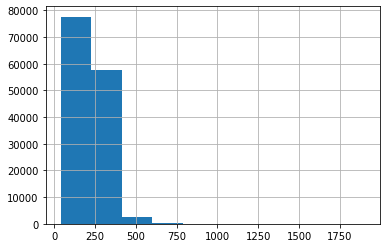

In [ ]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Train_resource.groupby('domain')['label']\
              .value_counts()

domain                             label   
ACEInhibitors.csv                  negative     2041
                                   positive      166
ADHD.csv                           negative      701
                                   positive       80
Antihistamines.csv                 negative      190
                                   positive       87
Appenzeller-Herzog_2020.csv        negative     2182
                                   positive      161
AtypicalAntipsychotics.csv         negative      670
                                   positive      329
BPA.csv                            negative     6980
                                   positive      101
Bannach-Brown_2019.csv             negative     1347
                                   positive      251
BetaBlockers.csv                   negative     1552
                                   positive      267
CalciumChannelBlockers.csv         negative      824
                                   positive      246
Es

#### Test Resource

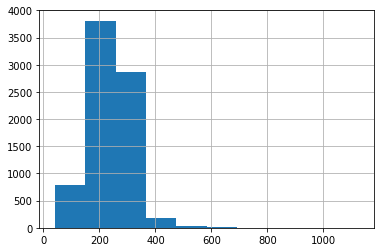

In [ ]:
Test_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Test_resource.groupby('domain')['label']\
              .value_counts()

domain                                label   
Distal_radius_fractures_approach.csv  negative     170
                                      positive      10
Hallux_valgus_prognostic.csv          negative     595
                                      positive      19
Head_and_neck_cancer_imaging.csv      negative      38
                                      positive      18
Obstetric_emergency_training.csv      negative     152
                                      positive      18
Pregnancy_medication.csv              negative     337
                                      positive      40
SR11_Li.csv                           negative     200
                                      positive       9
SR12_Cavender.csv                     negative     400
                                      positive      14
SR13_Chatterjee.csv                   negative     400
                                      positive      18
SR14_Funakoshi.csv                    negative    1000
                  

#### Validation Resource

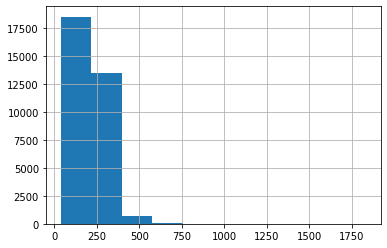

In [ ]:
Valid_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Valid_resource.groupby('domain')['label']\
              .value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## 📚 Meta learning phase

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ANTIGA CONFIGURAÇAO DO ARTIGO
# {
#   "inner_print": 2,
#   "bert_layers": 4,    ##############
#   "max_seq_length": 512,
#   "meta_epoch": 20,    ############
#   "k_spt": 8,  ###################
#   "k_qry": 8,
#   "outer_batch_size": 5,
#   "inner_batch_size": 4,
#   "outer_update_lr": 5e-05,
#   "inner_update_lr": 5e-5, ########
#   "inner_update_step": 4,  ##############
#   "inner_update_step_eval": 4,
#   "num_task_train": 20,
#   "pos_weight": 1.5,
#   "tresh": 0.9,
#   "model": "allenai/scibert_scivocab_uncased" ########
# }


# Meta-Training informations 
Info = {
    "device": device,
    "inner_print": 2,   
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-6, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

pprint(Info)
print('---'*5)
print(initializer_model.MODEL_NAME)

# SLR classifier model
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

# initializer_model.model.bert.encoder.layer[0].output.LayerNorm

# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          Test_resource=Test_resource,
          treat_text_fun=treat_text_fun)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-06,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}
---------------
allenai/scibert_scivocab_uncased
trainable params: 156306
Total params: 53371794


Meta epoch :   0%|                                       | 0/10 [00:00<?, ?it/s]


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Triptans.csv ----
Inner Loss:  1.1708690822124481
Inner Loss:  1.1579814702272415
Inner Loss:  1.164907768368721
----Task 1 : Neuropain.csv ----
Inner Loss:  1.1774069368839264
Inner Loss:  1.1650275588035583
Inner Loss:  1.1701831817626953
----Task 2 : SR10_Kourbeti.csv ----
Inner Loss:  1.1703444719314575
Inner Loss:  1.1729412972927094
Inner Loss:  1.151406079530716
----Task 3 : ACEInhibitors.csv ----
Inner Loss:  1.176506906747818
Inner Loss:  1.1667506694793701
Inner Loss:  1.1733826398849487
----Task 4 : CalciumChannelBlockers.csv ----
Inner Loss:  1.1812747865915298
Inner Loss:  1.1815973222255707
Inner Loss:  1.170683577656746


f1: 0.6666666865348816
recall: 1.0
Step: 0 	training Acc: 0.5

-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Bannach-Brown_2019.csv ----
Inner Loss:  1.183918833732605
Inner Loss:  1.1776015907526016
Inner Loss:  1.1768608689308167
----Task 1 : A

Meta epoch :  10%|███                            | 1/10 [00:52<07:51, 52.34s/it]

Step: 3 	training Acc: 0.5375

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : cereals.csv ----
Inner Loss:  1.1756126880645752
Inner Loss:  1.170541375875473
Inner Loss:  1.1484234035015106
----Task 1 : Transgenerational.csv ----
Inner Loss:  1.211701661348343
Inner Loss:  1.1990251988172531
Inner Loss:  1.1901432573795319
----Task 2 : Statins.csv ----
Inner Loss:  1.1768956184387207
Inner Loss:  1.117441862821579
Inner Loss:  1.1179182827472687
----Task 3 : ADHD.csv ----
Inner Loss:  1.206612378358841
Inner Loss:  1.1831878423690796
Inner Loss:  1.1820039004087448
----Task 4 : Wahono_2015.csv ----
Inner Loss:  1.1604306101799011
Inner Loss:  1.1457221657037735
Inner Loss:  1.156678169965744


f1: 0.7036326408386231
recall: 1.0
Step: 0 	training Acc: 0.575

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  1.2310852408409119
Inner Loss:  1.2101457566022873
Inner Loss:  1.2056919634342194
--

Meta epoch :  20%|██████▏                        | 2/10 [01:32<05:59, 44.93s/it]

Step: 3 	training Acc: 0.575

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : Nagtegaal_2019.csv ----
Inner Loss:  1.187450259923935
Inner Loss:  1.1566332876682281
Inner Loss:  1.160127878189087
----Task 1 : Estrogens.csv ----
Inner Loss:  1.1598352640867233
Inner Loss:  1.138151928782463
Inner Loss:  1.1478336304426193
----Task 2 : ACEInhibitors.csv ----
Inner Loss:  1.1917804777622223
Inner Loss:  1.1586327850818634
Inner Loss:  1.1575513184070587
----Task 3 : CalciumChannelBlockers.csv ----
Inner Loss:  1.175024151802063
Inner Loss:  1.1787355691194534
Inner Loss:  1.1632780581712723
----Task 4 : CalciumChannelBlockers.csv ----
Inner Loss:  1.1280074566602707
Inner Loss:  1.150758534669876
Inner Loss:  1.1246271431446075


f1: 0.6828459024429321
recall: 0.95
Step: 0 	training Acc: 0.5625

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  1.0574723482131958
Inner Loss:  1.03686222434043

Meta epoch :  30%|█████████▎                     | 3/10 [02:10<04:52, 41.85s/it]

Step: 3 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : Estrogens.csv ----
Inner Loss:  1.1645582914352417
Inner Loss:  1.1064135432243347
Inner Loss:  1.1184739172458649
----Task 1 : ProtonPumpInhibitors.csv ----
Inner Loss:  1.0676642954349518
Inner Loss:  1.1384101510047913
Inner Loss:  1.06844262778759
----Task 2 : AtypicalAntipsychotics.csv ----
Inner Loss:  1.1457545459270477
Inner Loss:  1.1380281746387482
Inner Loss:  1.1272448301315308
----Task 3 : Wahono_2015.csv ----
Inner Loss:  1.0988751202821732
Inner Loss:  1.0856295973062515
Inner Loss:  1.0752570927143097
----Task 4 : Leafy_Greens.csv ----
Inner Loss:  1.1941607296466827
Inner Loss:  1.190228432416916
Inner Loss:  1.1504167765378952


f1: 0.6606060624122619
recall: 0.925
Step: 0 	training Acc: 0.525

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : cereals_Future_set.csv ----
Inner Loss:  1.1182992160320282
Inner Loss:  1.1072761118412018
Inn

Meta epoch :  40%|████████████▍                  | 4/10 [02:49<04:04, 40.70s/it]

Step: 3 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : Leafy_Greens.csv ----
Inner Loss:  1.1332318484783173
Inner Loss:  1.072806030511856
Inner Loss:  1.0761926472187042
----Task 1 : Statins.csv ----
Inner Loss:  1.1205919682979584
Inner Loss:  1.1508464068174362
Inner Loss:  1.1477087885141373
----Task 2 : BetaBlockers.csv ----
Inner Loss:  1.1338608711957932
Inner Loss:  1.118405044078827
Inner Loss:  1.1004531979560852
----Task 3 : Kwok_2020.csv ----
Inner Loss:  1.1369601786136627
Inner Loss:  1.1108081340789795
Inner Loss:  1.0838137567043304
----Task 4 : cereals_Future_set.csv ----
Inner Loss:  1.2276541739702225
Inner Loss:  1.223799154162407
Inner Loss:  1.1872151643037796


f1: 0.678787910938263
recall: 0.95
Step: 0 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : Bannach-Brown_2019.csv ----
Inner Loss:  1.1266687661409378
Inner Loss:  1.1306700706481934
Inner Loss:  1.08253508

Meta epoch :  50%|███████████████▌               | 5/10 [03:29<03:22, 40.51s/it]

Step: 3 	training Acc: 0.625

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : SR10_Kourbeti.csv ----
Inner Loss:  0.9482043832540512
Inner Loss:  1.0177195221185684
Inner Loss:  0.9779494851827621
----Task 1 : Post_intensive_care_treatment.csv ----
Inner Loss:  1.1268755495548248
Inner Loss:  1.128538817167282
Inner Loss:  1.140801951289177
----Task 2 : NSAIDS.csv ----
Inner Loss:  1.061541497707367
Inner Loss:  1.0366119742393494
Inner Loss:  1.0242025554180145
----Task 3 : Statins.csv ----
Inner Loss:  1.1270774602890015
Inner Loss:  1.117809221148491
Inner Loss:  1.1236813962459564
----Task 4 : Nagtegaal_2019.csv ----
Inner Loss:  1.153855100274086
Inner Loss:  1.1469173431396484
Inner Loss:  1.1708100885152817


f1: 0.7317171931266785
recall: 0.925
Step: 0 	training Acc: 0.65

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : ProtonPumpInhibitors.csv ----
Inner Loss:  1.1550939232110977
Inner Loss:  1.2123082280158997
Inner Lo

Meta epoch :  60%|██████████████████▌            | 6/10 [04:12<02:45, 41.34s/it]

Step: 3 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : cereals.csv ----
Inner Loss:  1.1724613308906555
Inner Loss:  1.1409210860729218
Inner Loss:  1.1673252880573273
----Task 1 : Antihistamines.csv ----
Inner Loss:  1.2474853694438934
Inner Loss:  1.1810023784637451
Inner Loss:  1.247152417898178
----Task 2 : AtypicalAntipsychotics.csv ----
Inner Loss:  1.1645912528038025
Inner Loss:  1.1108337491750717
Inner Loss:  1.1230015754699707
----Task 3 : Transgenerational.csv ----
Inner Loss:  1.2205267548561096
Inner Loss:  1.160370022058487
Inner Loss:  1.1926475167274475
----Task 4 : Appenzeller-Herzog_2020.csv ----
Inner Loss:  1.0837931036949158
Inner Loss:  1.0590159744024277
Inner Loss:  1.1173655986785889


f1: 0.6962489247322082
recall: 0.875
Step: 0 	training Acc: 0.6125

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  1.0939673036336899
Inner Loss:  1.062032535

Meta epoch :  70%|█████████████████████▋         | 7/10 [04:53<02:03, 41.15s/it]

Step: 3 	training Acc: 0.5625

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  1.201763540506363
Inner Loss:  1.1767692565917969
Inner Loss:  1.1723112165927887
----Task 1 : Nagtegaal_2019.csv ----
Inner Loss:  1.1595363020896912
Inner Loss:  1.1037168204784393
Inner Loss:  1.1427928805351257
----Task 2 : CalciumChannelBlockers.csv ----
Inner Loss:  1.0610977560281754
Inner Loss:  1.0366876125335693
Inner Loss:  1.071106106042862
----Task 3 : Hall_2012.csv ----
Inner Loss:  1.0153621435165405
Inner Loss:  0.9808627068996429
Inner Loss:  1.043682485818863
----Task 4 : Neuropain.csv ----
Inner Loss:  1.1534585654735565
Inner Loss:  1.1069344580173492
Inner Loss:  1.1366355419158936


f1: 0.6410207390785218
recall: 0.825
Step: 0 	training Acc: 0.5375

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : ProtonPumpInhibitors.csv ----
Inner Loss:  1.174802154302597
Inner Loss:  1.1574472486972809
In

Meta epoch :  80%|████████████████████████▊      | 8/10 [05:34<01:22, 41.16s/it]

Step: 3 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : Hall_2012.csv ----
Inner Loss:  1.0652919262647629
Inner Loss:  1.0497376769781113
Inner Loss:  1.0259806960821152
----Task 1 : Transgenerational.csv ----
Inner Loss:  1.1896965503692627
Inner Loss:  1.1885842233896255
Inner Loss:  1.2184583246707916
----Task 2 : UrinaryIncontinence.csv ----
Inner Loss:  0.9609546661376953
Inner Loss:  0.9936906397342682
Inner Loss:  0.9593924134969711
----Task 3 : Post_intensive_care_treatment.csv ----
Inner Loss:  1.1725567728281021
Inner Loss:  1.1935801208019257
Inner Loss:  1.2137968093156815
----Task 4 : van_Dis_2020.csv ----
Inner Loss:  1.1877176761627197
Inner Loss:  1.1800159513950348
Inner Loss:  1.1670497953891754


f1: 0.5778439104557037
recall: 0.7
Step: 0 	training Acc: 0.5

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : Leafy_Greens.csv ----
Inner Loss:  1.193709447979927
Inner Loss:  1.187144547700882
I

Meta epoch :  90%|███████████████████████████▉   | 9/10 [06:14<00:40, 40.82s/it]

Step: 3 	training Acc: 0.6375

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  1.2249462753534317
Inner Loss:  1.2264410555362701
Inner Loss:  1.1733592748641968
----Task 1 : Triptans.csv ----
Inner Loss:  0.9546642750501633
Inner Loss:  1.0057991445064545
Inner Loss:  0.9230895787477493
----Task 2 : Post_intensive_care_treatment.csv ----
Inner Loss:  1.224259927868843
Inner Loss:  1.1911451518535614
Inner Loss:  1.1488399505615234
----Task 3 : ADHD.csv ----
Inner Loss:  1.2301318943500519
Inner Loss:  1.1758747845888138
Inner Loss:  1.173089474439621
----Task 4 : Wahono_2015.csv ----
Inner Loss:  1.1380312889814377
Inner Loss:  1.075921356678009
Inner Loss:  1.12777841091156


f1: 0.6775271773338318
recall: 0.875
Step: 0 	training Acc: 0.5875

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : CalciumChannelBlockers.csv ----
Inner Loss:  1.0709592401981354
Inner Loss:  1.1412854492664337
Inn

Meta epoch : 100%|██████████████████████████████| 10/10 [06:54<00:00, 41.40s/it]

Step: 3 	training Acc: 0.525


## 📕 Model evaluation

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


### Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(Valid_resource,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Opiods.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(Valid_resource[Valid_resource['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


Opiods.csv
negative    1675
positive      41
Name: label, dtype: int64
k_suport_examples: 20
k_query_examples: 40


#### Untrained model

acc: 0.5


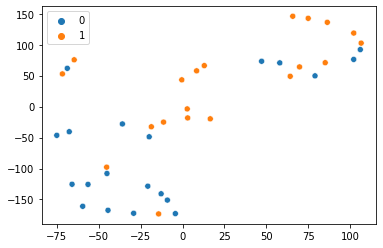

In [ ]:
#@title Untrainded model
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features[0].to('cpu'))


# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()


#### Trained model

Inner Loss:  0.9293918535113335
Inner Loss:  0.8876895159482956
Inner Loss:  0.8569481521844864
acc: 0.5


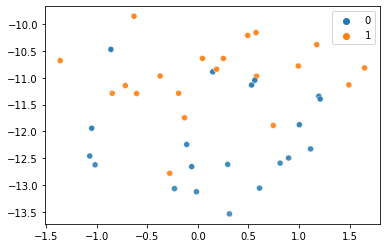

In [ ]:
#@title Trained model

model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()

## 📕 Domain learning phase
 
Evaluates the model in domain learner phase on the validation resource

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


### Tasks diagnosis

It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#another_cell)

In [ ]:
config = Info.copy()

config['tresh'] = 0.9
# config["inner_update_step_eval"] = 5
config["inner_print"] = 1
config["inner_update_lr"] = 5e-3
# config['inner_update_step'] = 10

pprint(config)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 1,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='sentence-transformers/paraphrase-mpnet-base-v2', vocab_size=30527, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 'tresh': 0.9}


Fluoride.csv
-------Train data-------
negative    8
positive    8
Name: label, dtype: int64
-------Test data-------
negative    3805
positive      41
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.7097, R: 0.9512
ASSWSS@95:0.7173
Acc.: 0.7681
F1-score: 0.0804
Treshold to wss95: 0.7910000085830688

Confusion matrix:
       Predict     
             0    1
Real 0    2915  890
     1       2   39

---Metrics with threshold: 0.9 ----

WSS@R:0.6654, R: 0.8537
AWSS@R:0.6726
Acc.: 0.8193
F1-score: 0.0915

Confusion matrix:
       Predict     
             0    1
Real 0    3116  689
     1       6   35


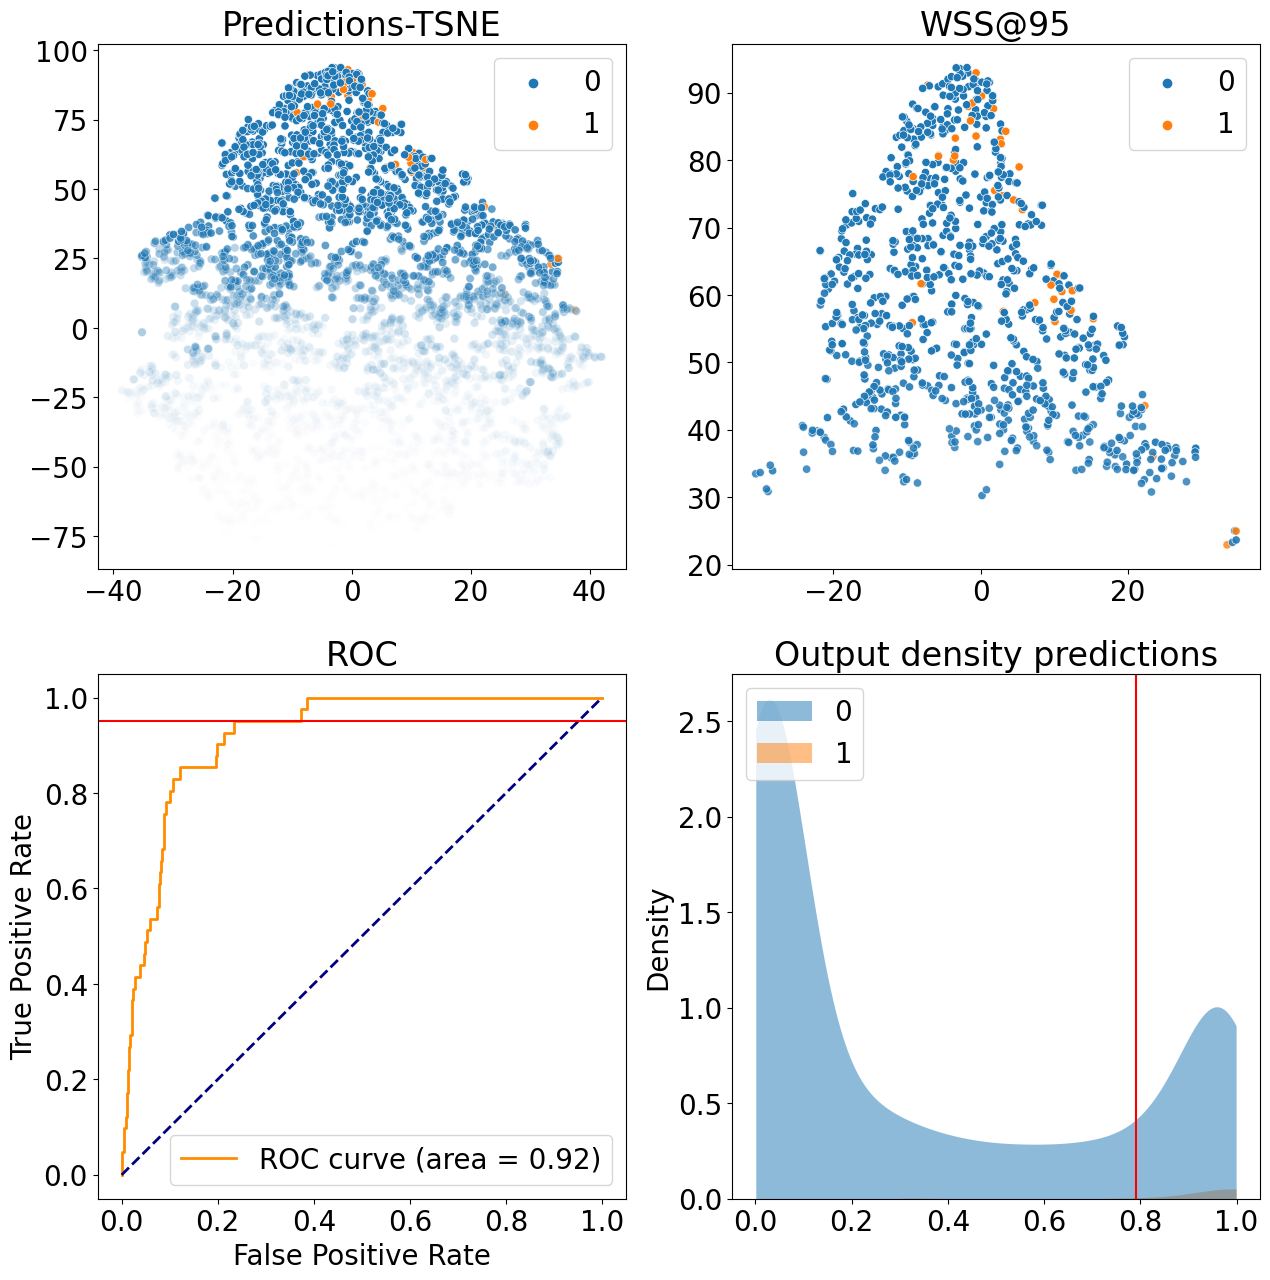

In [ ]:
#@title Evaluating validation dataset
batch_size_test =   200 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()


diagnosis5050 = diagnosis(names,
                          Valid_resource,
                          batch_size_test,
                          model,
                          config,
                          treat_text_fun=treat_text_fun,
                          start=12,
                          )
diagnosis5050()

PFOS-PFOA.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    5821
positive      85
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:-0.0325, R: 0.9529
ASSWSS@95:-0.033
Acc.: 0.0276
F1-score: 0.0274
Treshold to wss95: 0.6177999973297119

Confusion matrix:
       Predict      
             0     1
Real 0      82  5739
     1       4    81

---Metrics with threshold: 0.9 ----

WSS@R:0.0, R: 0.0
AWSS@R:0.0
Acc.: 0.9856
F1-score: 0.0

Confusion matrix:
       Predict   
             0  1
Real 0    5821  0
     1      85  0


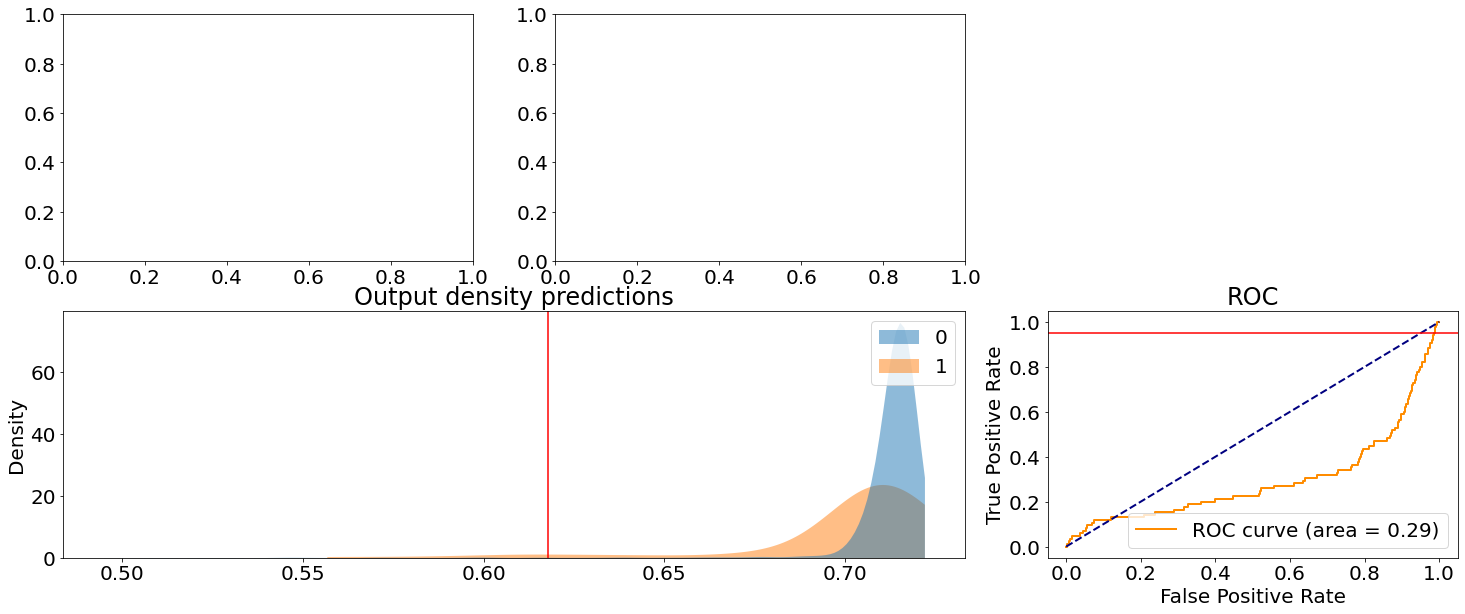

In [ ]:
#@title Evaluating validation dataset (without meta-learning and adapters)
batch_size_test =   150 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()

modelx = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = False,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

# Trainable parammeters
print('trainable params:', sum(p.numel() for p in modelx.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in modelx.parameters()))

diagnosis5050 = diagnosis(names,
                          Valid_resource,
                          batch_size_test,
                          modelx,
                          config,
                          treat_text_fun=treat_text_fun,
                          start=0)
diagnosis5050()

PFOS-PFOA.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    5821
positive      85
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.7091, R: 0.9529
ASSWSS@95:0.7195
Acc.: 0.7692
F1-score: 0.1062
Treshold to wss95: 0.7031999826431274

Confusion matrix:
       Predict      
             0     1
Real 0    4462  1359
     1       4    81

---Metrics with threshold: 0.9 ----

WSS@R:0.5886, R: 0.6941
AWSS@R:0.5972
Acc.: 0.9001
F1-score: 0.1667

Confusion matrix:
       Predict     
             0    1
Real 0    5257  564
     1      26   59


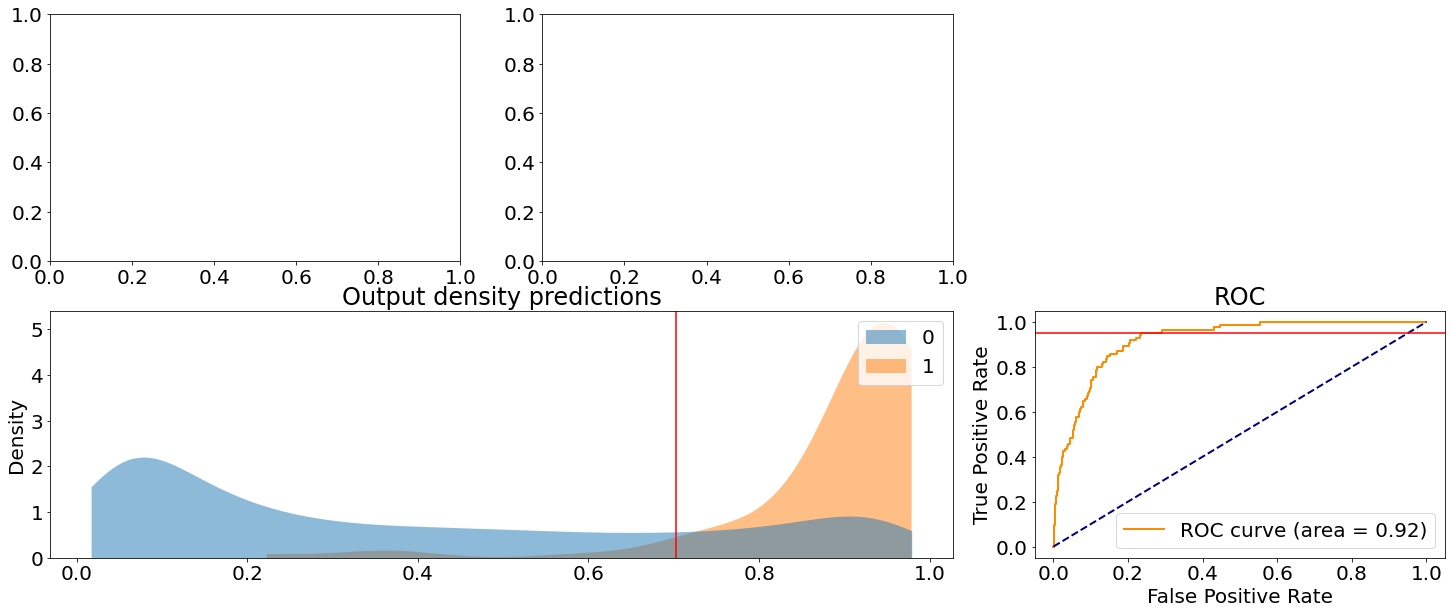

In [ ]:
#@title Evaluating validation dataset (without meta-learning)
batch_size_test =   200 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()

modelx = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

# Trainable parammeters
print('trainable params:', sum(p.numel() for p in modelx.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in modelx.parameters()))

diagnosis5050 = diagnosis(names,
                          Valid_resource,
                          batch_size_test,
                          modelx,
                          config,
                          treat_text_fun=treat_text_fun,
                          start=0)
diagnosis5050()

### Domain Text Avaliation of Positives examples <a id='Text_avaliation'></a>

In [ ]:
data_test = diagnosis5050.data_test
logits = diagnosis5050.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

index                                                  2152
text      Perfluorooctanoic acid alters T lymphocyte phe...
domain                                        PFOS-PFOA.csv
label                                              positive
Name: 2144, dtype: object
Predicted: 0.9989989399909973
Treated Text:
('perfluorooctanoic acid alters t lymphocyte phenotypes and cytokine '
 'expression in mice.perfluorooctanoic acid in the spleen, and proto-oncogene, '
 'c-myc, in the spleen and thymus. in conclusion, our data demonstrated that '
 'pfoa has an immunomodulatory effect by altering t lymphocyte phenotypes and '
 'gene expression of proinflammatory cytokines.')
Text:
('perfluorooctanoic acid alters t lymphocyte phenotypes and cytokine '
 'expression in mice.perfluorooctanoic acid in the spleen, and proto-oncogene, '
 'c-myc, in the spleen and thymus. in conclusion, our data demonstrated that '
 'pfoa has an immunomodulatory effect by altering t lymphocyte phenotypes and '
 'gene expre

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = '5050split'
path_save = "./"+"Models/"+base_path+"/"


# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
path_to_save= f"{path_save}/{check}"
Path(path_to_save).mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")
save_info.pop("device")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model.state_dict(), model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

Data e hora do salvamento: 2023_03_11_hr_17_53_56


In [ ]:
import os
import shutil


# Define os diretórios A e B
diretorio_a = '/content/gdrive/MyDrive'

diretorio_b = model_path
diretorio_b = meta_info_path

# Cria a pasta "RESULTADOS" em A
caminho_resultados = os.path.join(diretorio_a, 'RESULTADOS_SLR')

try: 
  os.makedirs(caminho_resultados) 
except:
  print("e")
  

# Move a pasta do diretório B para a pasta "RESULTADOS" em A
shutil.move(path_to_save, caminho_resultados)
print("saved:", os.path.join(caminho_resultados, path_to_save))

e
saved: /content/gdrive/MyDrive/RESULTADOS_SLR/./Models/5050split//2023_03_11_hr_17_53_56


## Load model

In [ ]:
# Downloading entire model
# Config the model that was saved

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Meta-Training informations 
Info = {
    "device": device,
    "inner_print": 2,   
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-6, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}




model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

path_mod = './gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Sentece_Transformers/Results/5050split/2023_03_09_hr_05_43_34/model.pt'
# path_mod = './gdrive/MyDrive/RESULTADOS_SLR (main)/Scibert/Results/5050split/2023_03_11_hr_17_53_56/model.pt'
# path_mod = '/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Scibert/Results/5050split/2023_03_11_hr_17_53_56/model.pt'

model.load_state_dict(torch.load(path_mod))
model

SLR_Classifier(
  (loss_fn): BCEWithLogitsLoss()
  (Encoder): Encoder(
    (model): MPNetModel(
      (embeddings): MPNetEmbeddings(
        (word_embeddings): Embedding(30527, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MPNetEncoder(
        (layer): ModuleList(
          (0-3): 4 x MPNetLayer(
            (attention): MPNetAttention(
              (attn): MPNetSelfAttention(
                (q): Linear(in_features=768, out_features=768, bias=True)
                (k): Linear(in_features=768, out_features=768, bias=True)
                (v): Linear(in_features=768, out_features=768, bias=True)
                (o): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (LayerNorm): LayerNorm((768,), eps=1e-05, elem

## 📗 Computing simulation attemps (50-50)


5 attemps in the domain learner phase with the validation resource is computed to evaluate the performance of the model.

In [ ]:
names_to_valid = Valid_resource['domain'].unique()

In [ ]:
# names that will be validated
print(names_to_valid)

['PFOS-PFOA.csv' 'Fluoride.csv' 'Head_and_neck_cancer_bone.csv'
 'Shoulder_replacement_diagnostic.csv' 'Shoulder_replacement_surgery.csv'
 'Distal_radius_fractures_closed_reduction.csv' 'Vascular_access.csv'
 'Total_knee_replacement.csv' 'Leafy_Greens_Future_set.csv'
 'Radjenovic_2013.csv' 'Kitchenham_2010.csv' 'Bos_2018.csv'
 'Wolters_2018.csv' 'SkeletalMuscleRelaxants.csv' 'Opiods.csv']


In [ ]:
data_valid =info_load[  info_load['names'].isin(names_to_valid)]
data_valid

,size,pos,neg,names,paths
17,3870,49,3821,Fluoride.csv,SLR_data/SWIFT systematic review data/Fluoride...
18,5950,95,5855,PFOS-PFOA.csv,SLR_data/SWIFT systematic review data/PFOS-PFO...
21,228,32,196,Head_and_neck_cancer_bone.csv,SLR_data/Medical Guidelines Dutch Association ...
22,329,3,326,Shoulder_replacement_diagnostic.csv,SLR_data/Medical Guidelines Dutch Association ...
24,376,6,370,Shoulder_replacement_surgery.csv,SLR_data/Medical Guidelines Dutch Association ...
25,180,4,176,Distal_radius_fractures_closed_reduction.csv,SLR_data/Medical Guidelines Dutch Association ...
30,728,19,709,Vascular_access.csv,SLR_data/Medical Guidelines Dutch Association ...
31,311,25,286,Total_knee_replacement.csv,SLR_data/Medical Guidelines Dutch Association ...
35,95,62,33,Leafy_Greens_Future_set.csv,SLR_data/Automatic classification of literatur...
37,6000,48,5952,Radjenovic_2013.csv,SLR_data/asreview/Radjenovic_2013.csv


In [ ]:
# that have at least 8 
names_to_valid_8g = data_valid.loc[data_valid['pos'] > 8, 'names'].tolist()
names_to_valid_8g

['Fluoride.csv',
 'PFOS-PFOA.csv',
 'Head_and_neck_cancer_bone.csv',
 'Vascular_access.csv',
 'Total_knee_replacement.csv',
 'Leafy_Greens_Future_set.csv',
 'Radjenovic_2013.csv',
 'Kitchenham_2010.csv',
 'Bos_2018.csv',
 'Wolters_2018.csv',
 'SkeletalMuscleRelaxants.csv',
 'Opiods.csv']

In [ ]:
pprint(Info)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-06,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}


In [ ]:

Info['tresh'] = 0.9
Info['inner_update_lr'] = 5e-3
config = Info.copy()
config.pop('tokenizer')

PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Scibert/'

# path_save =   google_drive_path + "Results/"+base_path+"/"

base_path = '5050split'

path_save =  google_drive_path + "Results/"+base_path+"/"

path_save
# save_google('/content/results',path_save)

'./gdrive/MyDrive/RESULTADOS_SLR/Scibert/Results/5050split/'

In [ ]:
pprint(Info)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'tresh': 0.9}


In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = names_to_valid_8g,  ## Coloque aqui qual que vai ser 
                    path_save = path_save, 
                    model=model, epochs=[Info['inner_update_step']], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 200)

gc.collect()
torch.cuda.empty_cache()

# wandb.finish()

# 🛸 Ablation

In [ ]:


ablation = {
    # Aplicar no aprender a aprender
    'bert_layers': [2,4,6,12],
    # Aplicar no aprender a tarefa
    'epochs': [4, 8, 16],
    'k_spt': [2,4, 8, 16],  # Tamanho do banco de treino (N-exemplos por classe)
    "adapters": [False, True],
    # Bancos de dados
    'names_ablation' : [
        'PFOS-PFOA.csv',            #
        'Fluoride.csv',             #
        'Kitchenham_2010.csv',      #
        'Opiods.csv']               #
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Meta-Training informations 
Info = {
    "device": device,
    "inner_print": 2,   
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-6, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}




config = Info.copy()
config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3
pprint(Info)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-06,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='sentence-transformers/paraphrase-mpnet-base-v2', vocab_size=30527, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})}


## Ablation finetunning (apreder a tarefa)

### Epochs

Modelo Treinado com Meta-Learning


In [ ]:
google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Sentece_Transformers/' 
# +\
#                      'Scibert/'


path_save =  google_drive_path + 'Results/Ablation/Epochs/meta_model/'
path_save

'./gdrive/MyDrive/RESULTADOS_SLR/Sentece_Transformers/Results/Ablation/Epochs/meta_model/'

In [ ]:
Info['tresh'] = 0.9
config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3

pipeline_simulation(Valid_resource = Valid_resource,
                    # names_to_valid = ablation['names_ablation'], 
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=model, 
                    epochs=ablation['epochs'], Info=config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5,
                    batch_test= 250,
                    tsne = False, make_plot = False)

Dont exist: metrics.csv, creating a new one.
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:29<00:00,  3.71s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:23<00:00,  3.46s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:22<00:00,  3.42s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:22<00:00,  3.45s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:31<00:00,  3.82s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:31<00:00,  3.82s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:30<00:00,  3.75s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.40s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:22<00:00,  3.42s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.32s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.34s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.33s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.34s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.33s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.34s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.33s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.33s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:53<00:00,  3.35s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.21s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.25s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.22s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.22s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.27s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.26s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.25s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.23s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:22<00:00,  3.24s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.37s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.39s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.36s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.37s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.38s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.39s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.36s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.33s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.32s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.37s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.41s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.39s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.39s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.37s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.39s/it]


Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Scibert/'

# path_save =   google_drive_path + "Results/"+base_path+"/"

path_save =  google_drive_path + 'Results/Ablation/Epochs/standart_model/'

path_save
# save_google('/content/results',path_save)

'./gdrive/MyDrive/RESULTADOS_SLR/Scibert/Results/Ablation/Epochs/standart_model/'

In [ ]:
standart_model = SLR_Classifier(
    bert_layers = range(Info["bert_layers"]),
    freeze_bert = ablation["adapters"][1], # True
    model = initializer_model.model.bert,
    # model = initializer_model.model.mpnet,
    drop=0.2,
    arch = 'bert',
    # arch = 'mpnet'
    )

# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=standart_model,
                    epochs=ablation['epochs'], Info=config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 250,
                    tsne = False, make_plot = False)

Dont exist: metrics.csv, creating a new one.
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:25<00:00,  3.55s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:15<00:00,  3.15s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:16<00:00,  3.18s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:16<00:00,  3.19s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:16<00:00,  3.20s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.22s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.22s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.23s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.24s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.23s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.25s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.24s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.23s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.24s/it]
Test validation | PFOS-PFOA.csv: 100%|██████████| 24/24 [01:17<00:00,  3.24s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.18s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.17s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:51<00:00,  3.21s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:51<00:00,  3.19s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.17s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:51<00:00,  3.20s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.17s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:56<00:00,  3.52s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.15s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:51<00:00,  3.21s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.18s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.17s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.17s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:50<00:00,  3.16s/it]
Test validation | Fluoride.csv: 100%|███████████| 16/16 [00:51<00:00,  3.19s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.05s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.14s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.12s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.09s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.10s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.10s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.09s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.12s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.04s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.13s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.11s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.04s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.12s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.12s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.06s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.22s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.22s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.17s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.26s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.18s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.20s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.23s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.22s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.34s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.36s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.30s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.30s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.31s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:23<00:00,  3.34s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.27s/it]


Modelo Treinado sem Meta-Learning e sem adapters, sem passar pela fazer de meta-learning

In [ ]:
google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Scibert/'

# path_save =   google_drive_path + "Results/"+base_path+"/"

path_save =  google_drive_path + f'Results/Ablation/Epochs/standart_model_wtA/'
path_save

'./gdrive/MyDrive/RESULTADOS_SLR/Scibert/Results/Ablation/Epochs/standart_model_wtA/'

In [ ]:
standart_model = SLR_Classifier(
    bert_layers = range(Info["bert_layers"]),
    freeze_bert = ablation["adapters"][0], # False
    model = initializer_model.model.bert,
    # model = initializer_model.model.mpnet,
    drop=0.2,
    arch = 'bert',
    # arch = 'mpnet'
    )

# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'][1:], 
                    path_save = path_save, 
                    model=standart_model,
                    epochs=ablation['epochs'], Info=config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 270,
                    tsne = False, make_plot = False)

Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:54<00:00,  3.62s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:50<00:00,  3.37s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.33s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:50<00:00,  3.37s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:54<00:00,  3.61s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.30s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.31s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.32s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.30s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:50<00:00,  3.35s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.27s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.27s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:50<00:00,  3.34s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.29s/it]
Test validation | Fluoride.csv: 100%|███████████| 15/15 [00:49<00:00,  3.29s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.05s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.03s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:20<00:00,  2.97s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.12s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.03s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.04s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.02s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.03s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.02s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.10s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.01s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.01s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.14s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.05s/it]
Test validation | Kitchenham_2010.csv: 100%|██████| 7/7 [00:21<00:00,  3.02s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.19s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.14s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.14s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.12s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.11s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.14s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.11s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.13s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.12s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.18s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.16s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.15s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:21<00:00,  3.10s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.15s/it]
Test validation | Opiods.csv: 100%|███████████████| 7/7 [00:22<00:00,  3.21s/it]


### DataTrain size

Modelo Treinado com Meta-Learning


In [ ]:
# google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/'  +\
#                      'Sentece_Transformers/'
google_drive_path = './gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Scibert/'
# path_save =   google_drive_path + "Results/"+base_path+"/"

  # path_save = './Results/Ablation/DataSize/meta_model/'
path_save =  google_drive_path + 'Results/Ablation/DataSize/meta_model/'
path_save

'./gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Scibert/Results/Ablation/DataSize/meta_model/'

In [ ]:
Info['tresh'] = 0.9
config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3

config = Info.copy()
for data_size in ablation['k_spt']:
  config['k_spt'] = data_size

  # model
  pipeline_simulation(Valid_resource = Valid_resource,
                      names_to_valid = ablation['names_ablation'], 
                      path_save = path_save, 
                      model=model, 
                      epochs=[config['inner_update_step']], Info=config,
                      treat_text_fun = treat_text_fun,
                      initializer_model = initializer_model,
                      n_attempt=5, batch_test= 200,
                      tsne = False, make_plot = False)

Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.27s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.31s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.34s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.48s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.39s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.37s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.35s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.39s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.36s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.38s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.35s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.38s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.34s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.36s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.36s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.31s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:21<00:00,  2.34s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.32s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.30s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:20<00:00,  2.33s/it]


Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
google_drive_path = './gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Sentece_Transformers/'



# path_save =   google_drive_path + "Results/"+base_path+"/"

# path_save = './Results/Ablation/DataSize/meta_model/'
# path_save =  google_drive_path + 'Results/Ablation/DataSize/standart_model/'
path_save =   google_drive_path + 'Results/Ablation/DataSize/standart_model/'
path_save

'./gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Sentece_Transformers/Results/Ablation/DataSize/standart_model/'

In [ ]:
Info['tresh'] = 0.9
config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3
config = Info.copy()

for data_size in ablation['k_spt']:
  config['k_spt'] = data_size

  # path_save = './Results/Ablation/DataSize/standart_model/'

  standart_model = SLR_Classifier(
      bert_layers = range(Info["bert_layers"]),
      freeze_bert = True,
      # model = initializer_model.model.bert,
      model = initializer_model.model.mpnet,
      drop=0.2,
      # arch = 'bert',
      arch = 'mpnet'
      )



  # model
  pipeline_simulation(Valid_resource = Valid_resource,
                      names_to_valid = ablation['names_ablation'], 
                      path_save = path_save, 
                      model=standart_model,
                      epochs=[config['inner_update_step']], Info=config,
                      treat_text_fun = treat_text_fun,
                      initializer_model = initializer_model,
                      n_attempt=5, batch_test= 200,
                      tsne = False, make_plot = False)

Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:28<00:00,  2.96s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:20<00:00,  2.67s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.65s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:20<00:00,  2.68s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.60s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.60s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:52<00:00,  2.62s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.48s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.46s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.51s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.47s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.45s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.62s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.55s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.65s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.54s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.57s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.65s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.65s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.63s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:52<00:00,  2.63s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:52<00:00,  2.60s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.58s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.50s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.48s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.45s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.49s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.45s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.60s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.52s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.54s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.57s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.55s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.65s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.63s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.63s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.58s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.59s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.58s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.48s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:21<00:00,  2.43s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.45s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.47s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.51s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.57s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.53s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.54s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.57s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:23<00:00,  2.56s/it]


Alredy exist: metrics.csv
------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.61s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.57s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.55s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.58s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:52<00:00,  2.60s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [00:51<00:00,  2.58s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:21<00:00,  2.43s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:21<00:00,  2.41s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:21<00:00,  2.44s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:22<00:00,  2.47s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:21<00:00,  2.41s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.55s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.50s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.54s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.52s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:22<00:00,  2.50s/it]


## Ablation (size model)

Treinar o modelo na faze de meta learning e testar com as configurações padrões achadas nos experimento 50-50 (configurações do `Info`)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Info = {
    "device": device,
    "inner_print": 2,   
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-6, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

In [ ]:
pprint(Info)
config = Info.copy()

Info['tresh'] = 0.9
config['tresh'] = 0.9

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-06,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='sentence-transformers/paraphrase-mpnet-base-v2', vocab_size=30527, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})}


## Voltar aqui


In [ ]:
tentativa_do_ablation = 1 ## TROCAR AQUI QUAL VAI SER A QUANTIDADE DE LAYERS conforme em ablation = {...}
config["bert_layers"] = ablation['bert_layers'][tentativa_do_ablation]


### Modelo Treinado com Meta-Learning


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# SLR classifier model
model_ablation = SLR_Classifier(bert_layers = range(config["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,      # Trocar se é o mpnet
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'                              # Trocar se é o mpnet
                       arch = 'mpnet'
                       )


# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model_ablation,
          # device = device,
          Info = Info,
          print_epoch =False,
          size_layer=config["bert_layers"],
          # Test_resource=Test_resource,    # Não precisa testar
          treat_text_fun=treat_text_fun)

In [ ]:
# google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/'
# google_drive_path = './gdrive/MyDrive/RESULTADOS_SLR (main)/Scibert/'
google_drive_path = './gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Sentece_Transformers/'

# path_save =   google_drive_path + "Results/"+base_path+"/"

# path_save = './Results/Ablation/DataSize/meta_model/'
path_save =  google_drive_path + 'Results/Ablation/Size/meta_model/'
path_save

'./gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/Sentece_Transformers/Results/Ablation/Size/meta_model/'

In [ ]:
# model

config['inner_update_lr'] = 5e-3
config['tresh'] = 0.9

pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=model_ablation, 
                    epochs= [config['inner_update_step']], Info=config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 150,
                    tsne = False, make_plot = False)

### Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
config["bert_layers"] = ablation['bert_layers'][tentativa_do_ablation]

In [ ]:
# tentativa_do_ablation = 1 ## TROCAR AQUI QUAL VAI SER A QUANTIDADE DE LAYERS conforme em ablation = {...}

# config["bert_layers"] = ablation['bert_layers'][3]
google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/'

path_save =  google_drive_path + f'Results/Ablation/Size/standart_model/'
path_save

'./gdrive/MyDrive/RESULTADOS_SLR/Results/Ablation/Size/12/standart_model/'

In [ ]:
standart_model = SLR_Classifier(
    bert_layers = range(config["bert_layers"]),
    
    freeze_bert = True,
    # model = initializer_model.model.bert,
    model = initializer_model.model.mpnet,
    drop=0.2,
    # arch = 'bert',
    arch = 'mpnet')

config['inner_update_lr'] = 5e-3
config['tresh'] = 5e-3

# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=standart_model,
                    epochs=[config['inner_update_step']], Info=config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 200,
                    tsne = False, make_plot = False)

------------ attempt 0 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [03:29<00:00,  6.99s/it]


------------ attempt 1 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [03:18<00:00,  6.63s/it]


------------ attempt 2 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [03:17<00:00,  6.58s/it]


------------ attempt 3 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [03:17<00:00,  6.60s/it]


------------ attempt 4 ------------


Test validation | PFOS-PFOA.csv: 100%|██████████| 30/30 [03:17<00:00,  6.59s/it]


------------ attempt 0 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [02:09<00:00,  6.47s/it]


------------ attempt 1 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [02:09<00:00,  6.47s/it]


------------ attempt 2 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [02:09<00:00,  6.48s/it]


------------ attempt 3 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [02:09<00:00,  6.47s/it]


------------ attempt 4 ------------


Test validation | Fluoride.csv: 100%|███████████| 20/20 [02:10<00:00,  6.55s/it]


------------ attempt 0 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:55<00:00,  6.21s/it]


------------ attempt 1 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:55<00:00,  6.16s/it]


------------ attempt 2 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:55<00:00,  6.14s/it]


------------ attempt 3 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:55<00:00,  6.14s/it]


------------ attempt 4 ------------


Test validation | Kitchenham_2010.csv: 100%|██████| 9/9 [00:55<00:00,  6.14s/it]


------------ attempt 0 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:57<00:00,  6.36s/it]


------------ attempt 1 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:57<00:00,  6.36s/it]


------------ attempt 2 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:59<00:00,  6.62s/it]


------------ attempt 3 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:57<00:00,  6.40s/it]


------------ attempt 4 ------------


Test validation | Opiods.csv: 100%|███████████████| 9/9 [00:57<00:00,  6.34s/it]


TypeError: ignored

# 🎁 Benchmark simulation (Benchmark)

This section explore the methodology of train the ML-SLRC with the remain dataset that don't correspond the Benchmarks datasets, [SWIFT](https://pubmed.ncbi.nlm.nih.gov/27216467/) and [cohen Drugs Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1447545/) to peform a comparison of WSS@95 in the ([Kusa at al., 2022](https://arxiv.org/abs/2201.07534)).


### 🎫 Data


#### Directory creation

In [ ]:
import glob
import os

path = 'SLR_data'

cohen_paths = glob.glob(f"{path}/**/cohen/*.csv", recursive=True)
SWIFT_paths = glob.glob(f"{path}/**/SWIFT systematic review data/*.csv", recursive=True)

cohen_names = [os.path.basename(p) for p in cohen_paths]
SWIFT_names = [os.path.basename(p) for p in SWIFT_paths]

base_path = 'Comparison'

#### Data split

In [ ]:
# Loading descriptive statistics
info_load = load_data_statistics(paths)

info_load.head()

,size,pos,neg,names,paths
0,209,9,200,SR11_Li.csv,SLR_data/Screening PubMed abstracts_ is class ...
1,414,14,400,SR12_Cavender.csv,SLR_data/Screening PubMed abstracts_ is class ...
2,206,6,200,SR4_Li.csv,SLR_data/Screening PubMed abstracts_ is class ...
3,413,13,400,SR3_Segelov.csv,SLR_data/Screening PubMed abstracts_ is class ...
4,832,32,800,SR6_Wang.csv,SLR_data/Screening PubMed abstracts_ is class ...


In [ ]:
from itertools import chain

All_data = load_data(
    info_load
)

All_data = All_data.dropna().reset_index().drop("index", axis=1)

comparison_names = list(chain.from_iterable([cohen_names, SWIFT_names]))

cohen_data = All_data[All_data['domain'].isin(cohen_names)]
cohen_data =  cohen_data.reset_index().drop("index", axis=1)

SWIFT_data = All_data[All_data['domain'].isin(SWIFT_names)]
SWIFT_data =  SWIFT_data.reset_index().drop("index", axis=1)

Train_resource = All_data[~All_data['domain'].isin(comparison_names)]
Train_resource =  Train_resource.reset_index().drop("index", axis=1)

In [ ]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

### 🔎🎫Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource



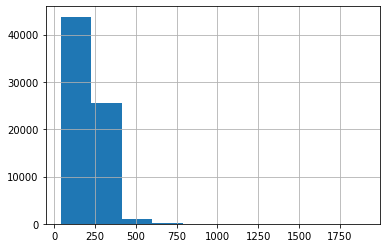

In [ ]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Train_resource.groupby('domain')['label']\
              .value_counts()

domain                       label   
Appenzeller-Herzog_2020.csv  negative    2182
                             positive     161
Bannach-Brown_2019.csv       negative    1347
                             positive     251
Bos_2018.csv                 negative    5593
                                         ... 
cereals_Future_set.csv       positive      71
van_Dis_2020.csv             negative    9738
                             positive     769
van_de_Schoot_2017.csv       negative    5065
                             positive     359
Name: label, Length: 88, dtype: int64

#### cohen Dataset

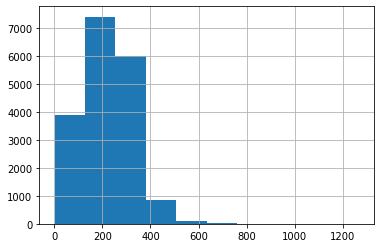

In [ ]:
cohen_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
cohen_data.groupby('domain')['label']\
              .value_counts()

domain                       label   
ACEInhibitors.csv            negative    2336
                             positive     182
ADHD.csv                     negative     746
                             positive      81
Antihistamines.csv           negative     211
                             positive      89
AtypicalAntipsychotics.csv   negative     727
                             positive     359
BetaBlockers.csv             negative    1715
                             positive     297
CalciumChannelBlockers.csv   negative     908
                             positive     267
Estrogens.csv                negative     277
                             positive      77
NSAIDS.csv                   negative     295
                             positive      86
Opiods.csv                   negative    1809
                             positive      46
OralHypoglycemics.csv        negative     352
                             positive     138
ProtonPumpInhibitors.csv     negative    1

#### SWIFT Dataset

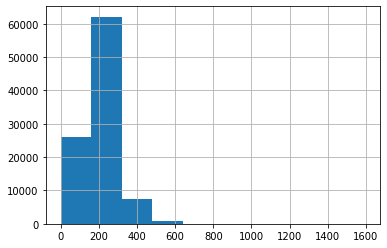

In [ ]:
SWIFT_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
SWIFT_data.groupby('domain')['label']\
              .value_counts()

domain                 label   
BPA.csv                negative     7589
                       positive      111
Fluoride.csv           negative     4428
                       positive       51
Neuropain.csv          negative    24193
                       positive     5009
PFOS-PFOA.csv          negative     6233
                       positive       95
Transgenerational.csv  negative    47868
                       positive      765
Name: label, dtype: int64

## 📚 Meta learning phase

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ANTIGA CONFIGURAÇAO DO ARTIGO
# {
#   "inner_print": 2,
#   "bert_layers": 4,    ##############
#   "max_seq_length": 512,
#   "meta_epoch": 20,    ############
#   "k_spt": 8,  ###################
#   "k_qry": 8,
#   "outer_batch_size": 5,
#   "inner_batch_size": 4,
#   "outer_update_lr": 5e-05,
#   "inner_update_lr": 5e-5, ########
#   "inner_update_step": 4,  ##############
#   "inner_update_step_eval": 4,
#   "num_task_train": 20,
#   "pos_weight": 1.5,
#   "tresh": 0.9,
#   "model": "allenai/scibert_scivocab_uncased" ########
# }


# Meta-Training informations 
Info = {
    "device": device,
    "inner_print": 2,   
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-4, # Learning rate of task optimizer
    "inner_update_lr" : 5e-3, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

pprint(Info)
print('---'*5)
print(initializer_model.MODEL_NAME)

# SLR classifier model
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )


# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          # Test_resource=Test_resource,
          treat_text_fun=treat_text_fun)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 0.0005,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}
---------------
allenai/scibert_scivocab_uncased
trainable params: 156306
Total params: 53371794


Meta epoch :   0%|                                       | 0/10 [00:00<?, ?it/s]


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Post_intensive_care_treatment.csv ----
Inner Loss:  1.4585208594799042
Inner Loss:  0.3779413364827633
Inner Loss:  0.43617746606469154
----Task 1 : SR12_Cavender.csv ----
Inner Loss:  0.328924722969532
Inner Loss:  0.3977070637047291
Inner Loss:  0.6145599167793989
----Task 2 : van_Dis_2020.csv ----
Inner Loss:  0.4000605456531048
Inner Loss:  0.8113115355372429
Inner Loss:  0.3172367811203003
----Task 3 : SR5_Lv.csv ----
Inner Loss:  0.009239863293866316
Inner Loss:  0.007091928118218978
Inner Loss:  0.0068127418247361975
----Task 4 : SR3_Segelov.csv ----
Inner Loss:  0.2894340739585459
Inner Loss:  0.056837874154249825
Inner Loss:  0.06160738753775755


f1: 0.9073684215545654
recall: 0.975
Step: 0 	training Acc: 0.8875

-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Head_and_neck_cancer_bone.csv ----
Inner Loss:  0.14932844415307045
Inner Loss:  0.15116731263697147
Inner Loss:

Meta epoch :  10%|███                            | 1/10 [00:57<08:33, 57.08s/it]

Step: 3 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : SR14_Funakoshi.csv ----
Inner Loss:  0.0030856122612021863
Inner Loss:  0.0016630240570520982
Inner Loss:  0.866939839645056
----Task 1 : Appenzeller-Herzog_2020.csv ----
Inner Loss:  0.6771468594670296
Inner Loss:  0.595438651740551
Inner Loss:  0.13636574568226933
----Task 2 : Distal_radius_fractures_approach.csv ----
Inner Loss:  1.7238990118106206
Inner Loss:  0.6855300348252058
Inner Loss:  0.06663967420657475
----Task 3 : Hallux_valgus_prognostic.csv ----
Inner Loss:  1.4287604093551636
Inner Loss:  0.600329227745533
Inner Loss:  0.46932441741228104
----Task 4 : Kwok_2020.csv ----
Inner Loss:  0.914864081889391
Inner Loss:  0.3564697727560997
Inner Loss:  0.10002340748906136


f1: 0.8130175709724426
recall: 0.925
Step: 0 	training Acc: 0.7700000047683716

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : cereals_Future_set.csv ----
Inner Loss:  0.924

Meta epoch :  20%|██████▏                        | 2/10 [01:38<06:23, 47.89s/it]

Step: 3 	training Acc: 0.710984855890274

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : SR13_Chatterjee.csv ----
Inner Loss:  0.26441872864961624
Inner Loss:  0.10472399834543467
Inner Loss:  0.11523142992518842
----Task 1 : SR7_Zhou.csv ----
Inner Loss:  0.30529711209237576
Inner Loss:  0.0092364433221519
Inner Loss:  0.017265999311348423
----Task 2 : SR9_Douxfils.csv ----
Inner Loss:  0.002113022084813565
Inner Loss:  0.0011012258667809267
Inner Loss:  0.021073338730881613
----Task 3 : Shoulder_replacement_diagnostic.csv ----
Inner Loss:  0.011332212015986443
Inner Loss:  0.0039284722879529
Inner Loss:  0.0014696972211822867
----Task 4 : SR6_Wang.csv ----
Inner Loss:  0.31104714376851916
Inner Loss:  1.2265923365484923
Inner Loss:  0.09938083682209253


f1: 0.9749019742012024
recall: 1.0
Step: 0 	training Acc: 0.9721153855323792

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : Obstetric_emergency_training.csv ----
Inner Loss

Meta epoch :  30%|█████████▎                     | 3/10 [02:15<04:59, 42.85s/it]

Step: 3 	training Acc: 0.6898809492588043

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : Bannach-Brown_2019.csv ----
Inner Loss:  0.8780295699834824
Inner Loss:  0.6944621205329895
Inner Loss:  0.24429643154144287
----Task 1 : SR3_Segelov.csv ----
Inner Loss:  0.022892660927027464
Inner Loss:  0.3552304143086076
Inner Loss:  0.9509736221904556
----Task 2 : van_Dis_2020.csv ----
Inner Loss:  0.46416020207107067
Inner Loss:  0.5125595889985561
Inner Loss:  0.16992424614727497
----Task 3 : van_Dis_2020.csv ----
Inner Loss:  1.6553816497325897
Inner Loss:  0.5766848511993885
Inner Loss:  0.6409043073654175
----Task 4 : Shoulderdystocia_positioning.csv ----
Inner Loss:  1.5363895557820797
Inner Loss:  0.7482798099517822
Inner Loss:  0.017727782018482685


f1: 0.7013697743415832
recall: 0.7833333373069763
Step: 0 	training Acc: 0.6804487228393554

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : SR2_Meng.csv ----
Inner Loss:  0.03122

Meta epoch :  40%|████████████▍                  | 4/10 [02:51<04:02, 40.38s/it]

Step: 3 	training Acc: 0.8288461565971375

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : Head_and_neck_cancer_imaging.csv ----
Inner Loss:  0.376680864719674
Inner Loss:  0.45987236127257347
Inner Loss:  0.3147155921906233
----Task 1 : Wahono_2015.csv ----
Inner Loss:  0.28092611976899207
Inner Loss:  1.1670624478720129
Inner Loss:  0.9584061894565821
----Task 2 : Hallux_valgus_prognostic.csv ----
Inner Loss:  1.0309128165245056
Inner Loss:  0.6191630512475967
Inner Loss:  0.7888335771858692
----Task 3 : SR14_Funakoshi.csv ----
Inner Loss:  0.5283207008615136
Inner Loss:  0.015526840696111321
Inner Loss:  0.2875666485633701
----Task 4 : Post_intensive_care_treatment.csv ----
Inner Loss:  0.5203310213983059
Inner Loss:  0.31901950761675835
Inner Loss:  0.17964060604572296


f1: 0.8578328251838684
recall: 0.95
Step: 0 	training Acc: 0.8375

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : SR10_Kourbeti.csv ----
Inner Loss:  1.466

Meta epoch :  50%|███████████████▌               | 5/10 [03:29<03:17, 39.45s/it]

Step: 3 	training Acc: 0.6055555582046509

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : SR10_Kourbeti.csv ----
Inner Loss:  0.09823419339954853
Inner Loss:  0.5890364572405815
Inner Loss:  0.012775130453519523
----Task 1 : van_de_Schoot_2017.csv ----
Inner Loss:  0.3921255096793175
Inner Loss:  0.323785699903965
Inner Loss:  0.1662596371024847
----Task 2 : Wolters_2018.csv ----
Inner Loss:  1.5852501094341278
Inner Loss:  0.4816646873950958
Inner Loss:  1.0449728593230247
----Task 3 : SR4_Li.csv ----
Inner Loss:  1.868833839893341
Inner Loss:  1.0181590095162392
Inner Loss:  0.024797932244837284
----Task 4 : Head_and_neck_cancer_imaging.csv ----
Inner Loss:  0.2848192967940122
Inner Loss:  1.4716667935135774
Inner Loss:  0.9661145024001598


f1: 0.8248496294021607
recall: 0.875
Step: 0 	training Acc: 0.8125

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : Hall_2012.csv ----
Inner Loss:  0.46917796321213245
Inner Loss:  0.4056

Meta epoch :  60%|██████████████████▌            | 6/10 [04:07<02:35, 38.88s/it]

Step: 3 	training Acc: 0.7304487228393555

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : Bos_2018.csv ----
Inner Loss:  2.153824249903361
Inner Loss:  0.12241918966174126
Inner Loss:  0.1326462651292483
----Task 1 : Shoulder_replacement_diagnostic.csv ----
Inner Loss:  0.02561093680560589
Inner Loss:  0.014570268802344799
Inner Loss:  0.009049121290445328
----Task 2 : Head_and_neck_cancer_bone.csv ----
Inner Loss:  0.6591132432222366
Inner Loss:  0.5965756922960281
Inner Loss:  0.8019464910030365
----Task 3 : Bannach-Brown_2019.csv ----
Inner Loss:  1.1327208294533193
Inner Loss:  0.16903739050030708
Inner Loss:  0.7320786081254482
----Task 4 : SR8_Liu.csv ----
Inner Loss:  0.1730989944189787
Inner Loss:  0.1259885085746646
Inner Loss:  0.04102141922339797


f1: 0.8216541409492493
recall: 0.925
Step: 0 	training Acc: 0.7704545497894287

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : Kwok_2020.csv ----
Inner Loss:  1.179539710

Meta epoch :  70%|█████████████████████▋         | 7/10 [04:47<01:57, 39.30s/it]

Step: 3 	training Acc: 0.6625

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : Shoulderdystocia_recurrence.csv ----
Inner Loss:  0.02009030431509018
Inner Loss:  0.011658728122711182
Inner Loss:  0.02051432430744171
----Task 1 : SR9_Douxfils.csv ----
Inner Loss:  0.013198580437650284
Inner Loss:  0.0023281844332814217
Inner Loss:  2.065821290908692
----Task 2 : SR14_Funakoshi.csv ----
Inner Loss:  0.0027255324966972694
Inner Loss:  2.3774812222764012
Inner Loss:  0.30045745804090984
----Task 3 : Appenzeller-Herzog_2020.csv ----
Inner Loss:  1.0101469904184341
Inner Loss:  0.2597324810922146
Inner Loss:  0.11040970124304295
----Task 4 : Bannach-Brown_2019.csv ----
Inner Loss:  0.3412385918200016
Inner Loss:  1.3376307003200054
Inner Loss:  0.297987625002861


f1: 0.817600405216217
recall: 0.975
Step: 0 	training Acc: 0.7642307758331299

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : SR1_Yang.csv ----
Inner Loss:  0.2890651542693

Meta epoch :  80%|████████████████████████▊      | 8/10 [05:24<01:16, 38.36s/it]

Step: 3 	training Acc: 0.710897433757782

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : Kitchenham_2010.csv ----
Inner Loss:  1.2129466645419598
Inner Loss:  0.3924105353653431
Inner Loss:  0.11343585513532162
----Task 1 : Bannach-Brown_2019.csv ----
Inner Loss:  1.324083648622036
Inner Loss:  0.8011031784117222
Inner Loss:  0.3755653351545334
----Task 2 : Distal_radius_fractures_approach.csv ----
Inner Loss:  0.8257971803347269
Inner Loss:  0.766355166832606
Inner Loss:  0.13291041304667792
----Task 3 : Wahono_2015.csv ----
Inner Loss:  0.7629495710134506
Inner Loss:  0.2604827880859375
Inner Loss:  0.6499176695942879
----Task 4 : Leafy_Greens.csv ----
Inner Loss:  1.0452325567603111
Inner Loss:  0.5411003604531288
Inner Loss:  0.28307242691516876


f1: 0.8611008286476135
recall: 1.0
Step: 0 	training Acc: 0.8350000023841858

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : Obstetric_emergency_training.csv ----
Inner Loss:  0.

Meta epoch :  90%|███████████████████████████▉   | 9/10 [06:04<00:38, 38.96s/it]

Step: 3 	training Acc: 0.7233333349227905

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : SR11_Li.csv ----
Inner Loss:  0.022029252722859383
Inner Loss:  0.2279888540506363
Inner Loss:  1.5202668905258179
----Task 1 : SR7_Zhou.csv ----
Inner Loss:  0.005679913330823183
Inner Loss:  0.0016345273470506072
Inner Loss:  0.000497478264151141
----Task 2 : Bannach-Brown_2019.csv ----
Inner Loss:  0.6858968827873468
Inner Loss:  0.10233039921149611
Inner Loss:  0.07386619271710515
----Task 3 : SR5_Lv.csv ----
Inner Loss:  0.08989299150804679
Inner Loss:  0.008547664309541384
Inner Loss:  0.00692523301889499
----Task 4 : Total_knee_replacement.csv ----
Inner Loss:  0.046791440807282925
Inner Loss:  1.1465419253217988
Inner Loss:  0.014399979030713439


f1: 0.9155555844306946
recall: 1.0
Step: 0 	training Acc: 0.9055555582046508

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : SR11_Li.csv ----
Inner Loss:  0.05247195344418287
Inner Loss:

Meta epoch : 100%|██████████████████████████████| 10/10 [06:40<00:00, 40.03s/it]

Step: 3 	training Acc: 0.65


## 📕 Model evaluation

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(SWIFT_data,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Neuropain.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(SWIFT_data[SWIFT_data['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


#### Untrained model

In [ ]:
#@title Trained model padrão
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features[0].to('cpu'))


# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()


#### Trained model

In [ ]:
#@title Trained model padrão

model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()

## 📕 Domain learning phase on SWIFT datasets

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### 🔎 Diagnosis

In [ ]:
config = Info.copy()

config['tresh'] = 0.9
config["inner_update_step_eval"] = 6
config["inner_print"] = 1
config['inner_update_step'] = 6

pprint(config)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 1,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 5,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 0.0005,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'tresh': 0.9}


It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#Text_avaliation_2)

BPA.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    7579
positive     101
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.6553, R: 0.9505
ASSWSS@95:0.664
Acc.: 0.7167
F1-score: 0.0811
Treshold to wss95: 0.8744000196456909

Confusion matrix:
       Predict      
             0     1
Real 0    5408  2171
     1       5    96

---Metrics with threshold: 0.9 ----

WSS@R:0.6385, R: 0.9208
AWSS@R:0.647
Acc.: 0.7288
F1-score: 0.082

Confusion matrix:
       Predict      
             0     1
Real 0    5504  2075
     1       8    93


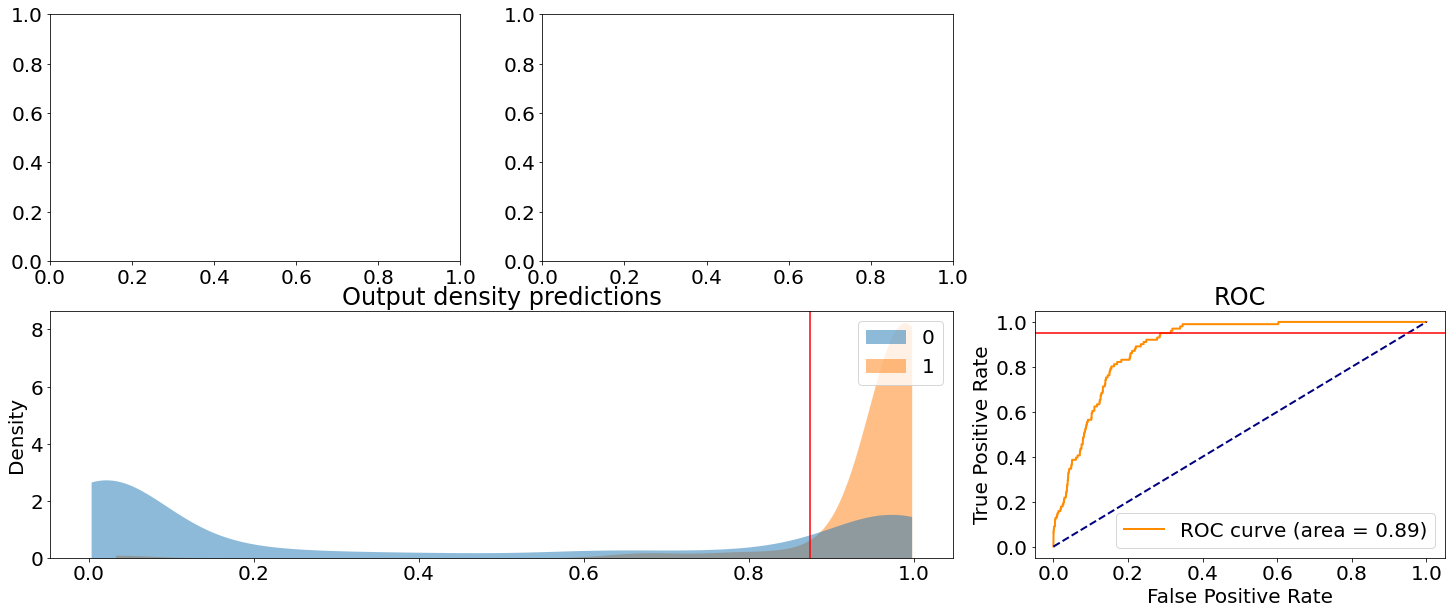

In [ ]:
#@title Evaluating validation dataset (without meta-learning)
batch_size_test =   250 #@param {type:"number"}
# Task names
names = SWIFT_data['domain'].unique()

modelx = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

diagnosis_comp = diagnosis(names,
                           SWIFT_data,
                           batch_size_test,
                           modelx,
                           config,
                           treat_text_fun=treat_text_fun,
                           start=0)
diagnosis_comp()

BPA.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    7579
positive     101
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.5325, R: 0.9505
ASSWSS@95:0.5396
Acc.: 0.5939
F1-score: 0.058
Treshold to wss95: 0.19480000436306

Confusion matrix:
       Predict      
             0     1
Real 0    4465  3114
     1       5    96

---Metrics with threshold: 0.9 ----

WSS@R:0.5701, R: 0.8317
AWSS@R:0.5777
Acc.: 0.7471
F1-score: 0.0796

Confusion matrix:
       Predict      
             0     1
Real 0    5654  1925
     1      17    84


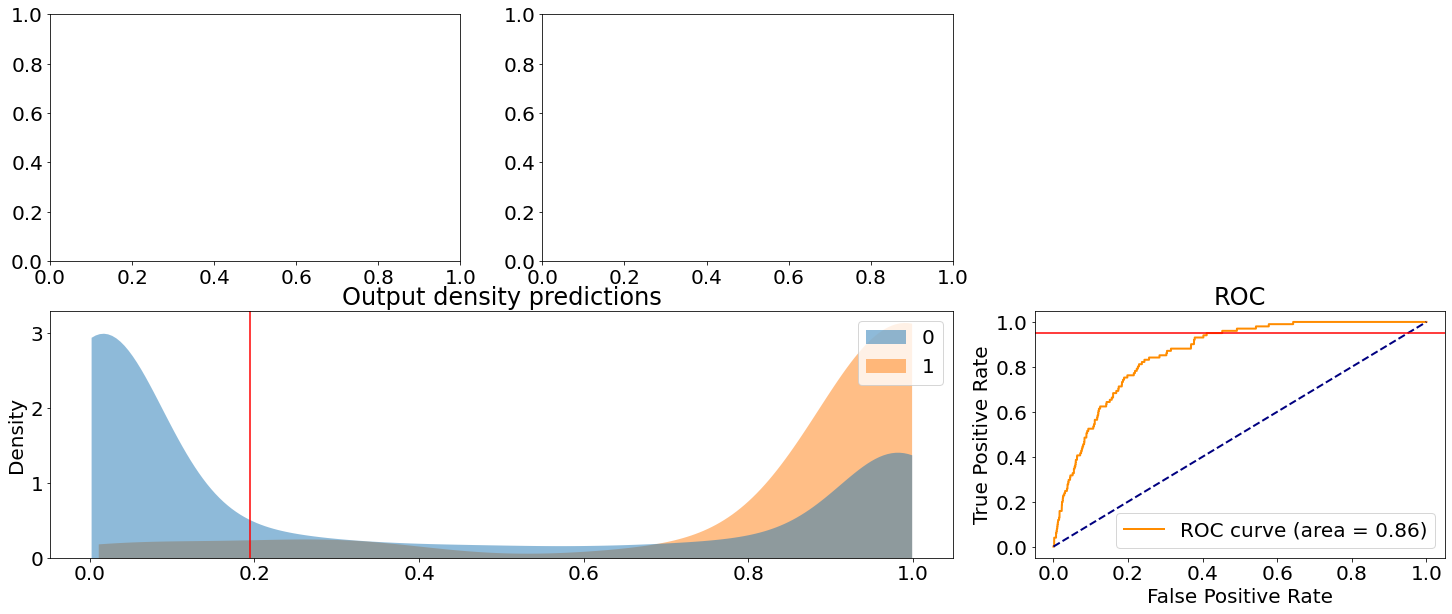

In [ ]:
#@title Evaluating validation dataset
batch_size_test =   200 #@param {type:"number"}
# Task names
names = SWIFT_data['domain'].unique()

diagnosis_comp = diagnosis(names,
                           SWIFT_data,
                           batch_size_test,
                           model,
                           config,
                           treat_text_fun=treat_text_fun,
                           start=0)
diagnosis_comp()

### 🔎 Text Avaliation of Positives examples <a id='Text_avaliation_2'></a>

In [ ]:
data_test = diagnosis_comp.data_test
logits = diagnosis_comp.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = 'benchmark'
path_save = "./"+"Models/"+base_path+"/"


# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
path_to_save= f"{path_save}/{check}"
Path(path_to_save).mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")
save_info.pop("device")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model.state_dict(), model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

Data e hora do salvamento: 2023_03_11_hr_22_52_03


In [ ]:
import os
import shutil


# Define os diretórios A e B
diretorio_a = '/content/gdrive/MyDrive'

diretorio_b = model_path
diretorio_b = meta_info_path

# Cria a pasta "RESULTADOS" em A
caminho_resultados = os.path.join(diretorio_a, 'RESULTADOS_SLR')

try: 
  os.makedirs(caminho_resultados) 
except:
  print("e")
  

# Move a pasta do diretório B para a pasta "RESULTADOS" em A
shutil.move(path_to_save, caminho_resultados)
print("saved:", os.path.join(caminho_resultados, path_to_save))

e
saved: /content/gdrive/MyDrive/RESULTADOS_SLR/./Models/benchmark//2023_03_11_hr_22_52_03


## Load model

In [ ]:
# Downloading entire model
# Config the model that was saved
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

model.state_dict(torch.load(model_path))
model

## 📗 Computing simulation attemps on SWIFT datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

pprint(SWIFT_names)

['Transgenerational.csv',
 'Neuropain.csv',
 'BPA.csv',
 'Fluoride.csv',
 'PFOS-PFOA.csv']


In [ ]:
info_load[  info_load['names'].isin(SWIFT_names)]

,size,pos,neg,names,paths
14,46147,606,45541,Transgenerational.csv,SLR_data/SWIFT systematic review data/Transgen...
15,29202,5009,24193,Neuropain.csv,SLR_data/SWIFT systematic review data/Neuropai...
16,7093,102,6991,BPA.csv,SLR_data/SWIFT systematic review data/BPA.csv
17,3870,49,3821,Fluoride.csv,SLR_data/SWIFT systematic review data/Fluoride...
18,5950,95,5855,PFOS-PFOA.csv,SLR_data/SWIFT systematic review data/PFOS-PFO...


In [ ]:
pprint(Info)
config = Info.copy()

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 0.0005,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}


In [ ]:
base_path= 'Benchmark'

google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Scibert/'

path_save =  google_drive_path + "Results/"+base_path+"/SWIFT/"
path_save

'./gdrive/MyDrive/RESULTADOS_SLR/Scibert/Results/Benchmark/SWIFT/'

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3

pipeline_simulation(Valid_resource = SWIFT_data,
                    names_to_valid = SWIFT_names,
                    path_save = path_save,
                    model = model, 
                    epochs=[config['inner_update_step']],
                    Info = config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 280)

## 📗 Computing simulation attemps on cohen datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

pprint(cohen_names)

['NSAIDS.csv',
 'BetaBlockers.csv',
 'Statins.csv',
 'OralHypoglycemics.csv',
 'ADHD.csv',
 'Antihistamines.csv',
 'UrinaryIncontinence.csv',
 'Estrogens.csv',
 'Triptans.csv',
 'AtypicalAntipsychotics.csv',
 'ACEInhibitors.csv',
 'ProtonPumpInhibitors.csv',
 'SkeletalMuscleRelaxants.csv',
 'Opiods.csv',
 'CalciumChannelBlockers.csv']


In [ ]:
info_load[  info_load['names'].isin(cohen_names)]

,size,pos,neg,names,paths
49,348,81,267,NSAIDS.csv,SLR_data/asreview/cohen/NSAIDS.csv
50,1819,266,1553,BetaBlockers.csv,SLR_data/asreview/cohen/BetaBlockers.csv
51,2659,150,2509,Statins.csv,SLR_data/asreview/cohen/Statins.csv
52,462,134,328,OralHypoglycemics.csv,SLR_data/asreview/cohen/OralHypoglycemics.csv
53,781,80,701,ADHD.csv,SLR_data/asreview/cohen/ADHD.csv
54,277,87,190,Antihistamines.csv,SLR_data/asreview/cohen/Antihistamines.csv
55,271,65,206,UrinaryIncontinence.csv,SLR_data/asreview/cohen/UrinaryIncontinence.csv
56,337,77,260,Estrogens.csv,SLR_data/asreview/cohen/Estrogens.csv
57,573,200,373,Triptans.csv,SLR_data/asreview/cohen/Triptans.csv
58,999,329,670,AtypicalAntipsychotics.csv,SLR_data/asreview/cohen/AtypicalAntipsychotics...


In [ ]:
pprint(Info)
config = Info.copy()

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 0.005,
 'inner_update_step': 6,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 0.0005,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}


In [ ]:
base_path= 'Benchmark'

google_drive_path = './gdrive/MyDrive/'+ 'RESULTADOS_SLR/' +\
                     'Scibert/'


path_save =  google_drive_path + "Results/"+base_path+"/Drugs/"
path_save

'./gdrive/MyDrive/RESULTADOS_SLR/Scibert/Results/Benchmark/Drugs/'

In [ ]:
config['tresh'] = 0.9
config['inner_update_lr'] = 5e-3

pipeline_simulation(Valid_resource = cohen_data,
                    names_to_valid = cohen_names,
                    path_save = path_save,
                    model = model, 
                    epochs=[config['inner_update_step']],
                    Info = config,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 200)

# ⛳ RESULTS SLR

In [ ]:
# names= ["Sentece_Transformers", "Scibert", "oBERT"][2]
# model = ["standart_model", "meta_model"][0]
# datas = []
# for n in ["2","4","6","12"]:
#  datas.append(pd.read_csv(f"/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/{names}/Results/Ablation/Size/{n}/{model}/metrics.csv",
#                           index_col = 0))


# pd.concat(datas).to_csv(f"/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/{names}/Results/Ablation/Size/{model}/metrics.csv")

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown '1-5Inr39tqHHjk7Lzr8oysPIZoQztw0U6' --folder -O /tmp/RESULTS_SLR
!gdown '1JQisfWTCYQiP6p1gNs7NapXaaHm2ZXNd' --folder -O /tmp/RESULTS_SLR
!gdown '1-ENdLVzgaXaUC3EZFHJCVGorEducBcdS' --folder -O /tmp/RESULTS_SLR
!gdown '10I5ok8DEmlsvVOXPtC8ujDpJYVKdJeo5' --folder -O /tmp/RESULTS_SLR

In [ ]:
import gdown

url = 'https://drive.google.com/drive/folders/1_KsKn0e_oIKdnsvh9N1X29GQYnlEk7xM?usp=sharing'
gdown.download_folder(
    url=url,
    # id='1_KsKn0e_oIKdnsvh9N1X29GQYnlEk7xM',
                      quiet=False, use_cookies=False)

In [ ]:

plot = sns.catplot(data = data1, kind="box",
          x="AWSS@95",
          y="name",
          hue="skull",
          row= names_ablation,
          col = 'skull_type',
          height=14, aspect=2)


plot.fig.subplots_adjust(hspace=0.1, wspace=.08)

# plt.grid()  #just add this
plt.ylabel('Name');
plt.xlim((0,1));

plot.add_legend(loc="lower center",
bbox_to_anchor=(.5, 1), ncol=3,title=None, frameon=False)


plt.savefig(f'plot-{names_ablation}.pdf')
plt.show()


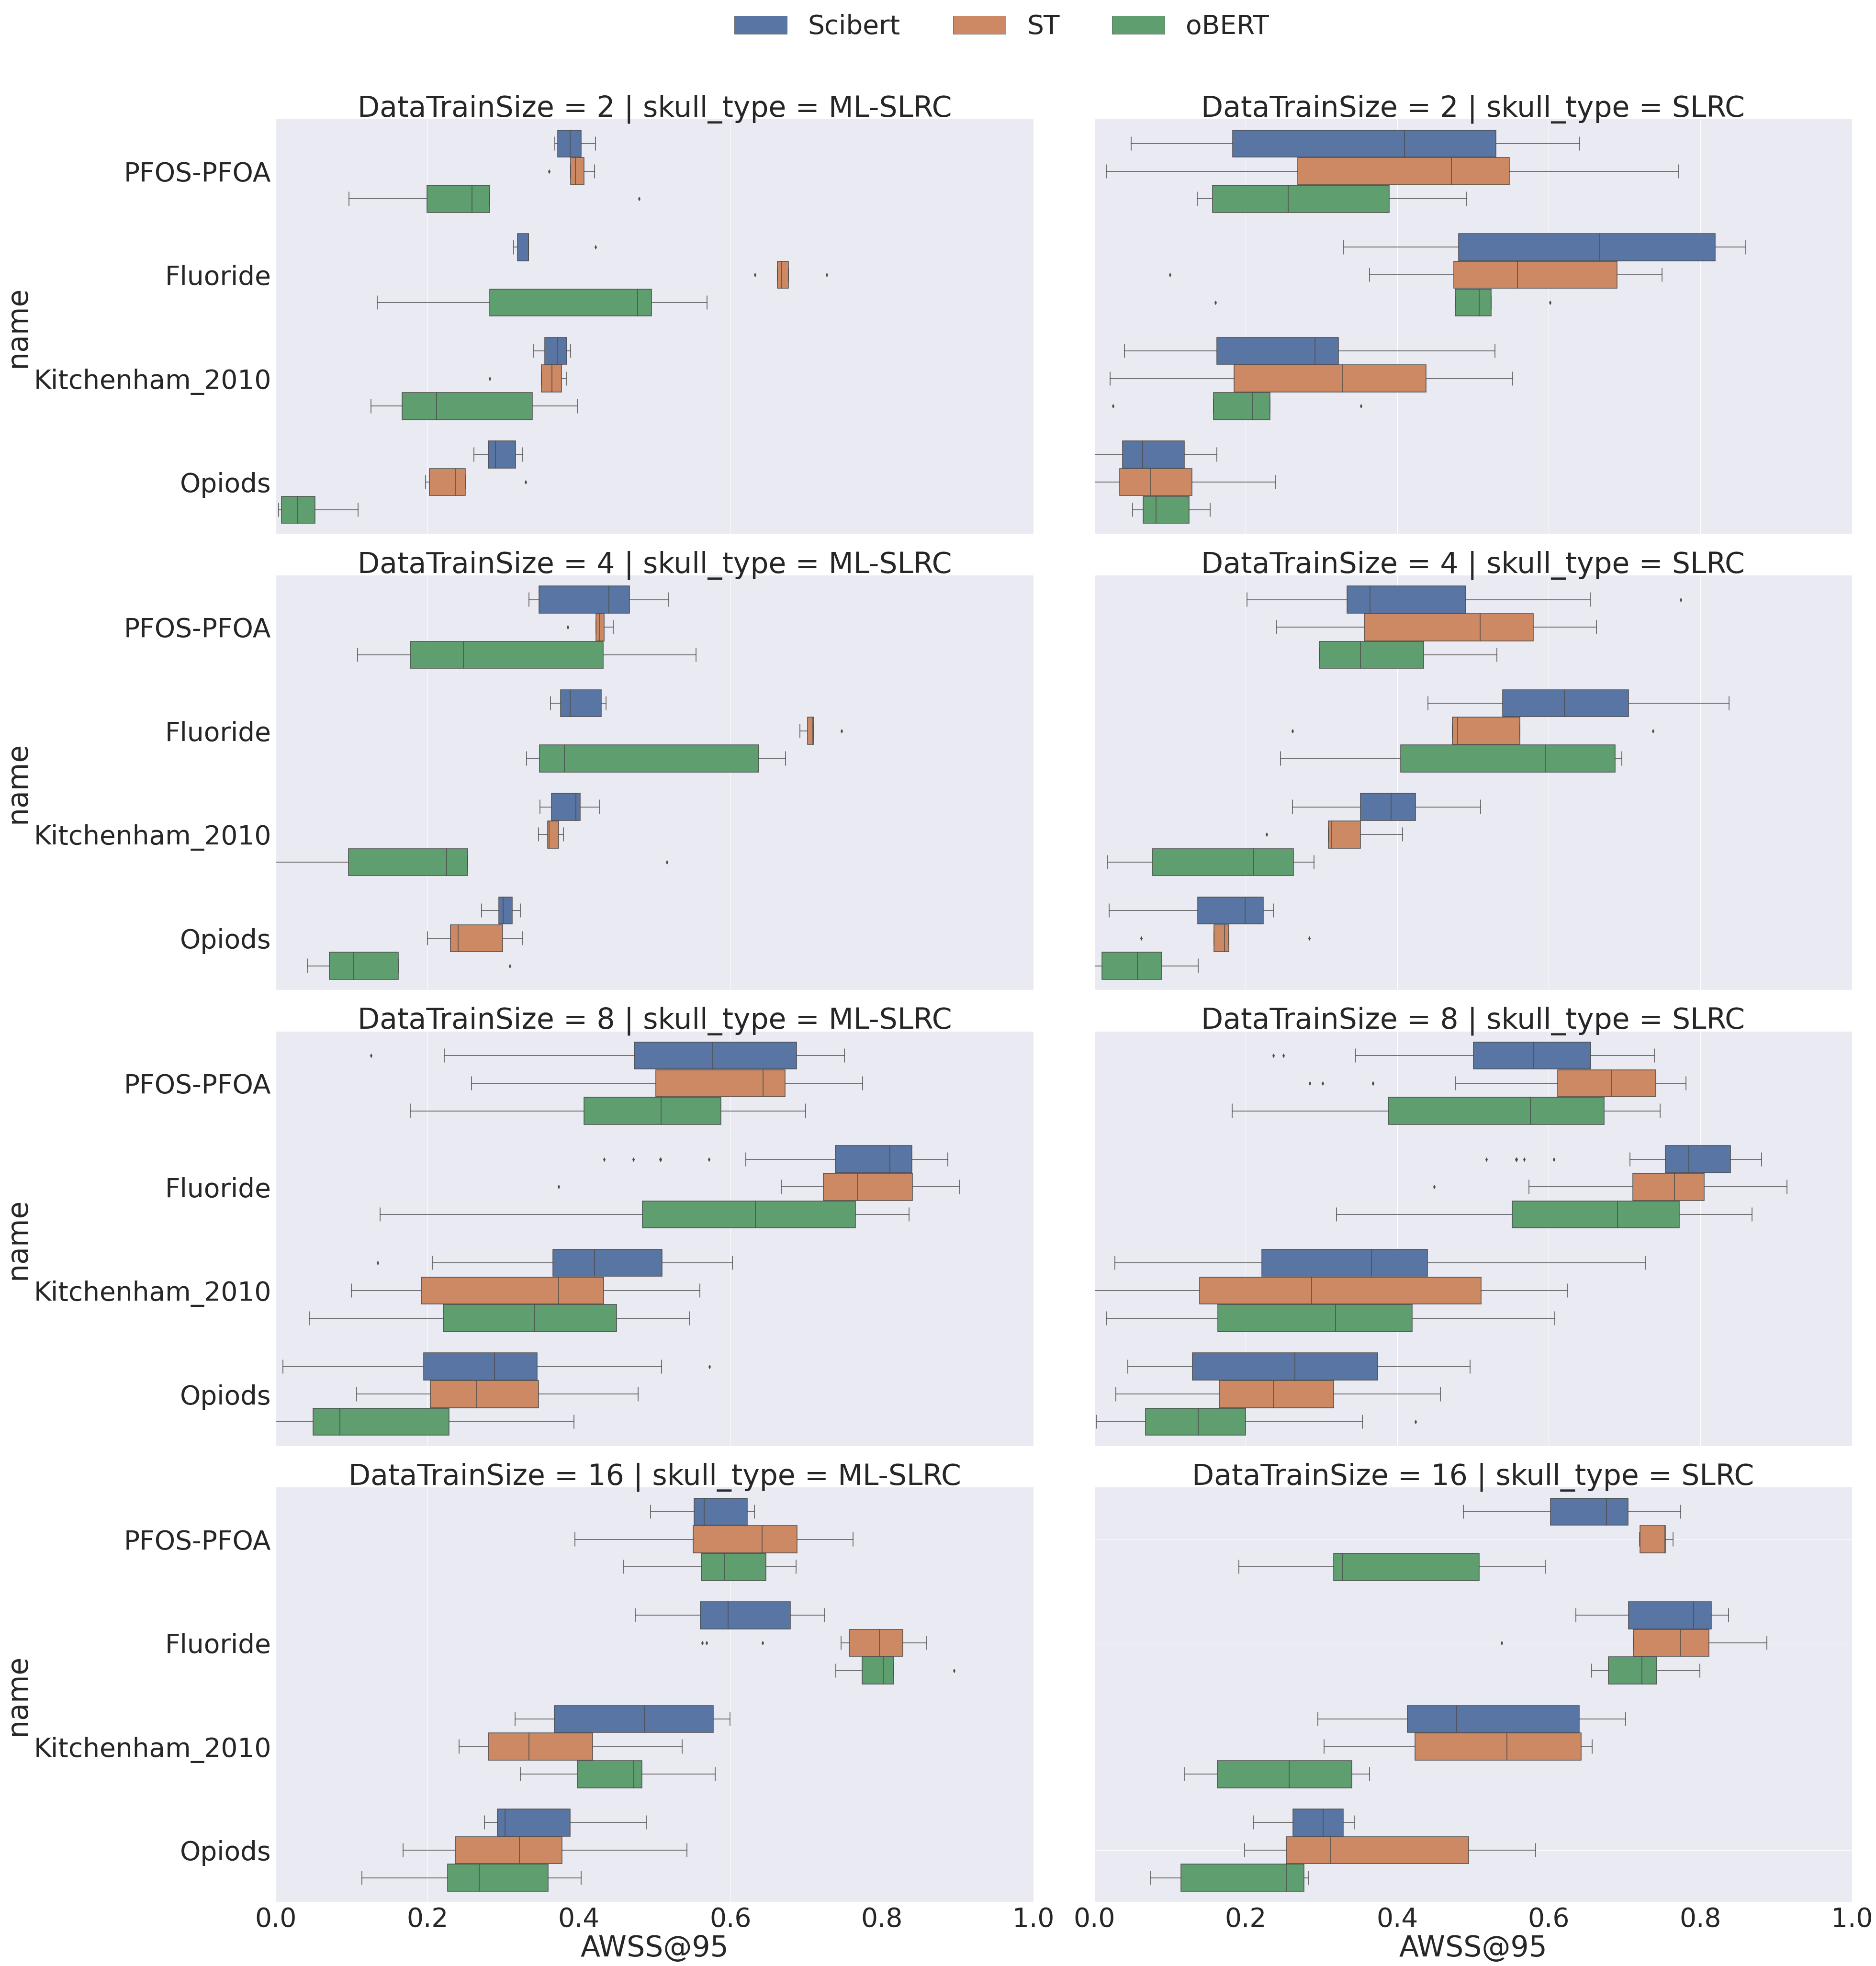

In [ ]:
sns.set(font_scale=5)

plot = sns.catplot(data = data1, kind="box",
          x="AWSS@95",
          y="name",
          hue="skull",
          row= names_ablation,
          col = 'skull_type',
          height=14, aspect=2)

sns.move_legend(
plot, "lower center",
bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

plot.fig.subplots_adjust(hspace=0.1, wspace=.08)

plt.grid()  #just add this
plt.ylabel('Name');
plt.xlim((0,1));

plot


/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/all/Ablation/metrics.csv
here
here


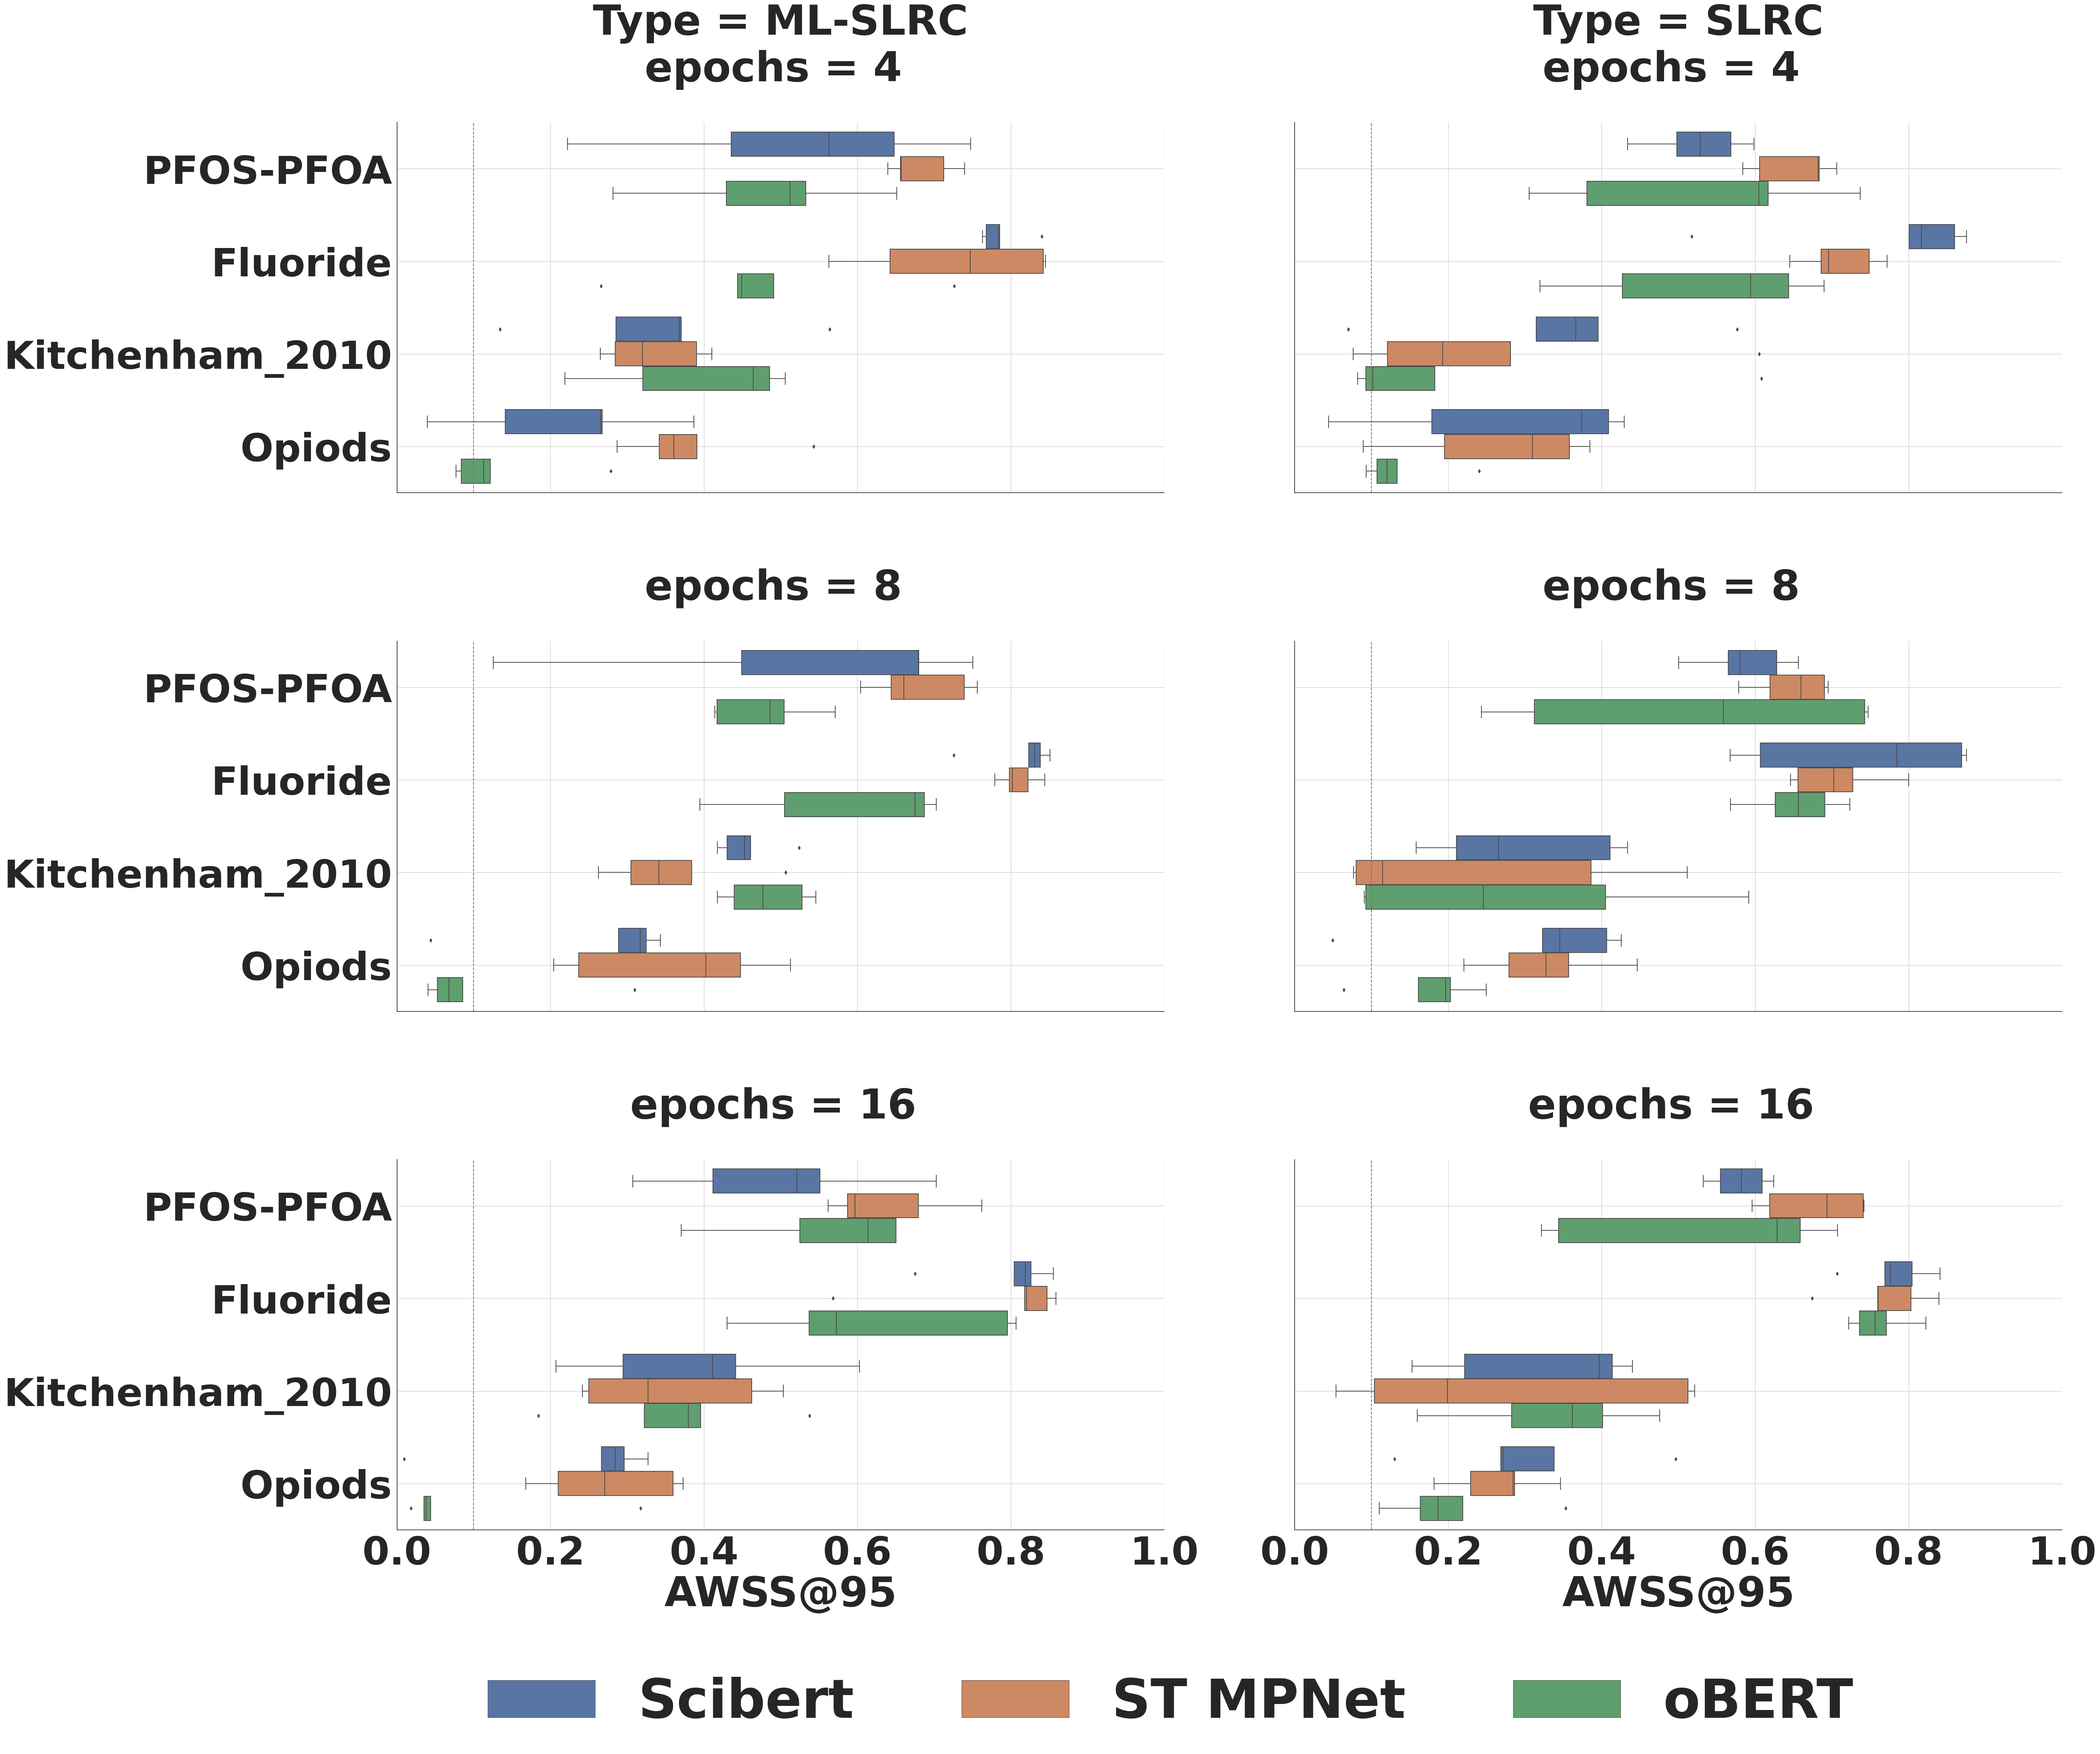

In [169]:
#@title Results ALL { run: "auto" }

#@markdown # Results ALL
#@markdown ---

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.weight"] = "bold"
import re


# results_path = "/content/RESULTADOS_SLR (main)/all"
results_path = "/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/all"
names_folders = "Ablation" #@param ['5050split', 'Ablation', 'Benchmark']
names_ablation = "epochs" #@param ['layer_size', 'epochs', 'DataTrainSize']


results = f"{results_path}/{names_folders}/metrics.csv"


try:
  print(results)
  data1 = pd.read_csv(results, index_col = 0)
  if names_folders == "Benchmark":
    groupby_names = ["name_Benchmark", 'name', "skull"]
  elif names_folders == "Ablation":
    groupby_names = ['name', "skull","skull_type", names_ablation]
  else:
    groupby_names = ['name', "skull"]

  data1_n = data1.groupby(groupby_names)
  # data1_n = data1_n.sample(5)
  data1_n = data1.groupby(groupby_names)
  data_results = data1_n.mean().round(2).astype(str) + "(" +\
  data1_n.std().round(2).astype(str) + ")"
  # print(data_results.loc[:, ["WSS@95", "AWSS@95",
  #                            "acc@95", "f1@95"]])
  
  print('here')
  data1['skull'] = data1['skull'].replace({'Sentece_Transformers': 'ST MPNet'})
  
  print('here')
  if names_folders == "Ablation":
    data1['skull_type'] = data1['skull_type'].replace({'meta_model': 'ML-SLRC',
                                'standart_model': 'SLRC',
                                'standart_model_wtA':'SLRC_woA'} )


    if names_ablation != 'epochs':
      data1 = data1[(data1['skull_type'] != 'SLRC_woA') & (data1['epochs']== 6)]
    else:
      data1 = data1[(data1['skull_type'] != 'SLRC_woA') & (data1['epochs']!= 6)]



    sns.set(font_scale=5)
    sns.set_style("white")


    plot = sns.catplot(data = data1, kind="box",
              x="AWSS@95",
              y="name",
              hue="skull",
              row= names_ablation,
              col = 'skull_type',
              height=14, aspect=2,
              legend=False)
    

    plot.fig.subplots_adjust(hspace=0.4, wspace=.17)

    for ax in plot.axes.flat:
      # ax.yaxis.set_tick_params(labelsize='large')
      ax.tick_params(axis='y', labelsize=75)
      ax.tick_params(axis='x', labelsize=75)
      
      
      ax.set_ylabel('')
      
      t = ax.get_title()
      if re.search('DataTrainSize = 2', t):
        if re.search('ML-SLRC', t):
          t = re.sub(r"\|.*", "", t)
          t = f"Type = ML-SLRC\n{t}"
        else:
          t = re.sub(r"\|.*", "", t)
          t = f"Type = SLRC\n{t}"

      elif re.search('layer_size = 2', t):
        if re.search('ML-SLRC', t):
          t = re.sub(r"\|.*", "", t)
          t = f"Type = ML-SLRC\n{t}"
        else:
          t = re.sub(r"\|.*", "", t)
          t = f"Type = SLRC\n{t}"

      elif re.search('epochs = 4', t):
        if re.search('ML-SLRC', t):
          t = re.sub(r"\|.*", "", t)
          t = f"Type = ML-SLRC\n{t}"
        else:
          t = re.sub(r"\|.*", "", t)
          t = f"Type = SLRC\n{t}"

      else:
        t = re.sub(r"\|.*", "", t)


      ax.set_title(t,pad=80, fontdict={'weight': "bold", 'fontsize': 80})

      l = ax.get_xlabel()
      ax.set_xlabel(l, fontdict={'weight': "bold", 'fontsize': 80})
      ax.grid()

      ax.axvline(x = 0.1, color = 'r',linestyle = 'dashed')

    plt.xlim((0,1));

    plot.add_legend()
    sns.move_legend(plot,
                    loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=True, ncol=3, fontsize='xx-large')


    plot.savefig(f'plot-{names_ablation}.pdf')
    plt.show()

  else:
    print('here')
    sns.set(font_scale=2)
    sns.set_style("white")


    sort_names = data1[data1["skull"] == "ST MPNet"].sort_values(by=["AWSS@95"], ascending=False)['name']

    plot = sns.catplot(data = data1, kind="box",
              x="AWSS@95",
              y="name",
              hue="skull",
              legend=False,
              order=sort_names.unique(),
              height=12, aspect=1)
    plt.axvline(x = 0.1, color = 'r',linestyle = 'dashed')


    plt.grid()  #just add this
    plot.add_legend()
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=18)
    sns.move_legend(plot,
                    loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=True, ncol=3)
    
    plt.ylabel('');
    plt.xlabel('AWSS@95', fontweight="bold", fontsize=20);
    plt.xlim((0,1));
    plot.savefig('plot.pdf')  



except:
  print("Dont exist:")
  print(results)



In [ ]:
data1.columns

Index(['WSS@95', 'AWSS@95', 'WSS@R', 'AWSS@R', 'Recall_WSS@95', 'Recall_WSS@R',
       'acc@95', 'acc@R', 'f1@95', 'f1@R', 'treshould@95', 'name',
       'layer_size', 'attempt', 'epochs', 'DataTrainSize', 'skull',
       'skull_type'],
      dtype='object')

In [ ]:
# importing the module
import matplotlib.pyplot as plt

import seaborn as sns

#increase font size of all elements
sns.set(font_scale=2)

sort_names = data1[data1["skull"] == "Sentece_Transformers"].sort_values(by=["AWSS@95"], ascending=False)['name']

plot = sns.catplot(data = data1, kind="box",
          x="AWSS@95",
          y="name",
          hue="skull",
          legend=False,
          order=sort_names.unique(),
          height=10, aspect=2)
plt.axvline(x = 0.1, color = 'r',linestyle = 'dashed')


plt.grid()  #just add this
plot.fig.legend(loc=(0.6,0.15))
plt.ylabel('Name');
plt.xlim((0,1));

In [ ]:
data1 = pd.read_csv(results, index_col = 0)
data1_n = data1.groupby(groupby_names)
data_results = data1_n.mean().round(2).astype(str) + "(" +\
data1_n.std().round(2).astype(str) + ")"

# data1.to_latex("test.tex")

print(data_results.loc[:, ["WSS@95", "AWSS@95"]].head(6).unstack(level=-1).stack(level=0).unstack(level=-1))

data_results.loc[:, ["WSS@95", "AWSS@95"]].unstack(level=-1).stack(level=0).unstack(level=-1).to_latex("benchmarkdata.tex")

skull                            Scibert             Sentece_Transformers  \
                                 AWSS@95      WSS@95              AWSS@95   
name_Benchmark name                                                         
Drugs          ACEInhibitors  0.21(0.11)  0.19(0.11)           0.12(0.06)   
               ADHD            0.42(0.1)  0.38(0.09)           0.59(0.07)   

skull                                          oBERT              
                                  WSS@95     AWSS@95      WSS@95  
name_Benchmark name                                               
Drugs          ACEInhibitors  0.11(0.06)  0.09(0.05)  0.09(0.05)  
               ADHD           0.54(0.06)  0.32(0.14)  0.29(0.13)  


<ipython-input-107-5bfd3769c357>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_results.loc[:, ["WSS@95", "AWSS@95"]].unstack(level=-1).stack(level=0).unstack(level=-1).to_latex("benchmarkdata.tex")


## Mergin to folder "all"

In [ ]:
## Results 5050split (creating "all" folder)

import pandas as pd


# results_path = "/content/RESULTADOS_SLR (main)"
results_path = "/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)"

names_model = ['Scibert', 'Sentece_Transformers', 'oBERT']
names_folders = ['5050split']

for n_results in names_folders:
  datas = []
  for n_model in names_model:
      results = f"{results_path}/{n_model}/Results/{n_results}/metrics.csv"
      try:
        data1 = pd.read_csv(results, index_col = 0)
        data1["skull"] = n_model
        datas.append(data1)
      except:
        print("Dont exist:")
        print(results)

  all_data = pd.concat(datas)
  all_data.to_csv(f'/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/all/{n_results}/metrics.csv')

In [ ]:
## Results Benchmark (creating "all" folder)

import pandas as pd


# results_path = "/content/RESULTADOS_SLR (main)"
results_path = "/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)"

names_model = ['Scibert', 'Sentece_Transformers', 'oBERT']
names_folders = ['Benchmark']
Benchmark_folders = ['Drugs', "SWIFT"]

for n_results in names_folders:
  datas = []
  for n_model in names_model:
    for n_Benchmark in Benchmark_folders:
      results = f"{results_path}/{n_model}/Results/{n_results}/{n_Benchmark}/metrics.csv"
      try:
        data1 = pd.read_csv(results, index_col = 0)
        data1["skull"] = n_model
        data1["name_Benchmark"] = n_Benchmark
        datas.append(data1)
      except:
        print("Dont exist:")
        print(results)

  all_data = pd.concat(datas)
  all_data.to_csv(f'/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/all/{n_results}/metrics.csv')

In [ ]:
## ABLATION (creatin "all" folder)

import pandas as pd

# results_path = "/content/RESULTADOS_SLR (main)"
results_path = "/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)"
names_model = ['Scibert', 'Sentece_Transformers', 'oBERT']
names_folders_ablation = ['Epochs', 'DataSize', 'Size']
names_folders_ablation_models = ['meta_model', 'standart_model', 'standart_model_wtA']


datas = []
for n_model in names_model:
  for n_ablation in names_folders_ablation:
    for n_ablation_model in names_folders_ablation_models:
      results_ablation = f"{results_path}/{n_model}/Results/Ablation/{n_ablation}/{n_ablation_model}/metrics.csv"
      try:
        data1 = pd.read_csv(results_ablation, index_col = 0)
        data1["skull"] = n_model
        data1["skull_type"] = n_ablation_model
        datas.append(data1)
      except:
        print("Dont exist:")
        print(results_ablation)

all_data

all_data = pd.concat(datas)
# all_data = all_data[all_data['epochs'].isin([4,8,16])]
all_data.to_csv('/content/gdrive/MyDrive/book_SLR_automation/main/RESULTADOS_SLR (main)/all/Ablation/metrics.csv')

,WSS@95,AWSS@95,WSS@R,AWSS@R,Recall_WSS@95,Recall_WSS@R,acc@95,acc@R,f1@95,f1@R,treshould@95,name,layer_size,attempt,epochs,DataTrainSize,skull,skull_type
0,0.4293,0.4357,0.4413,0.4479,0.9540,0.5057,0.488663,0.935702,0.052070,0.188034,0.211323,PFOS-PFOA,4,0,4,8,Scibert,meta_model
1,0.4427,0.4493,0.4310,0.4374,0.9540,0.5057,0.502030,0.925381,0.053393,0.166352,0.072000,PFOS-PFOA,4,0,8,8,Scibert,meta_model
2,0.4058,0.4119,0.3868,0.3926,0.9540,0.4598,0.465144,0.925888,0.049895,0.154440,0.000598,PFOS-PFOA,4,0,16,8,Scibert,meta_model
3,0.5547,0.5630,0.5810,0.5897,0.9540,0.6782,0.614044,0.908122,0.067838,0.178517,0.550104,PFOS-PFOA,4,1,4,8,Scibert,meta_model
4,0.6693,0.6793,0.6814,0.6916,0.9540,0.8391,0.728596,0.852284,0.093785,0.143278,0.566555,PFOS-PFOA,4,1,8,8,Scibert,meta_model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.0832,0.0849,0.1834,0.1870,0.9697,0.4545,0.131765,0.727059,0.041558,0.060729,0.590271,Opiods,12,0,6,8,oBERT,standart_model
16,0.1485,0.1515,0.3988,0.4067,0.9697,0.9394,0.197059,0.476471,0.044787,0.065126,0.816028,Opiods,12,1,6,8,oBERT,standart_model
17,0.3473,0.3542,0.3779,0.3854,0.9697,0.7879,0.395882,0.601177,0.058662,0.071233,0.841330,Opiods,12,2,6,8,oBERT,standart_model
18,0.1279,0.1305,-0.0135,-0.0138,0.9697,0.0606,0.176471,0.908824,0.043716,0.025157,0.612622,Opiods,12,3,6,8,oBERT,standart_model
